# Import libraries

In [2]:
%%capture
%pip install mne
%pip install ipympl
%pip install EMD-signal
%pip install -U imbalanced-learn
%pip install hyperopt
%pip install xgboost

# Instell this if you are using jupyter lab
# conda install -c conda-forge nodejs
# jupyter labextension install @jupyter-widgets/jupyterlab-manager
# jupyter lab build

In [3]:
# Import libraries

import os
import sys
import joblib
import re
import glob
from os.path import dirname, join as pjoin

import pandas as pd
import numpy as np
import random

# from google.colab import drive

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix, make_scorer

from imblearn.over_sampling import SMOTE, RandomOverSampler, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler

from tabulate import tabulate

# from __future__ import annotations

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score

from sklearn.svm import SVC
from hyperopt import hp, Trials, fmin, STATUS_OK, tpe
from xgboost import XGBClassifier

from typing import Dict, Any

# from scipy import signal
from scipy.stats import entropy, skew, kurtosis
from scipy.signal import butter, filtfilt
from scipy.io import loadmat
from scipy.signal import welch
from scipy.signal import stft
from scipy.signal import resample # Resample signal
from scipy.signal import firwin, lfilter
from scipy.signal import hilbert, periodogram, spectrogram

import nolds
from PyEMD import EMD

import matplotlib.pyplot as plt
import seaborn as sns

import neurokit2 as nk

import mne
import yasa

import warnings
warnings.filterwarnings("ignore")

c:\Users\manue\anaconda3\envs\trial\lib\site-packages\antropy\fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))


# Format Data

In [4]:
filenames, excerpts, visuals, hypnograms, automatic = [], [], [], [], []

for name in glob.glob('data/*excerpt*.txt'):
    # print(os.path.split(name)[1])

    filename = os.path.split(name)[1]
    filenames.append(filename)

    if 'Hypnogram' in filename:
      hypnograms.append(filename)
    elif 'Visual' in filename:
      visuals.append(filename)
    elif 'Automatic' in filename:
      automatic.append(filename)
    else:
      excerpts.append(filename)
      

In [5]:
# Import excerpts data
# df_excerpt = pd.concat([pd.read_csv('data/'+filename) for i, filename in enumerate(excerpts)], axis=1)
excerpt_sig_txt = [pd.read_csv('data/'+filename).values for i, filename in enumerate(excerpts)]

In [6]:
# Import Visual_scoringN_excerptN data

visual_data = []
for name in visuals:
    data = pd.read_csv('data/' + name, sep='\s+', names=['Spindles', 'C'])
    # print(data.head())
    # print(data.iloc[0][0].replace('[', '').replace(']', '').split('/'))
    col_names = data.iloc[0][0].replace('[', '').replace(']', '').split('/')
    data = data.drop(0)

    # rename multiple columns
    data = data.rename(columns={'Spindles': col_names[0], 'C': col_names[1]})

    data = data.apply(pd.to_numeric)

    visual_data.append(data)

df_visual = pd.concat(visual_data, axis=1)
df_visual.head()

,vis1_Spindles,C3-A1,vis1_Spindles,CZ-A1,vis1_Spindles,C3-A1,vis1_Spindles,CZ-A1,vis1_Spindles,CZ-A1,...,vis2_Spindles,CZ-A1,vis2_Spindles,C3-A1,vis2_Spindles,CZ-A1,vis2_Spindles,CZ-A1,vis2_Spindles,CZ-A1
1,282.24,0.72,0.80,0.80,500.22,1.07,22.02,1.15,13.67,0.87,...,0.725,1.0,297.86,1.0,217.54,1.0,13.590,1.0,6.295,1.0
2,311.72,1.54,6.96,1.26,891.87,1.46,26.02,1.48,20.09,0.50,...,7.150,1.0,387.94,1.0,473.54,1.0,19.905,1.0,31.625,1.0
3,340.28,0.72,22.98,0.85,945.00,0.70,29.89,0.78,30.80,1.28,...,14.825,1.0,500.28,1.0,629.20,1.0,30.845,1.0,84.670,1.0
4,366.83,0.65,26.09,1.28,975.04,0.76,36.52,0.63,33.17,0.59,...,26.120,1.0,509.62,1.0,653.01,1.0,32.950,1.0,94.090,1.0
5,373.74,0.50,31.50,0.74,986.24,0.61,41.41,0.91,36.74,0.52,...,31.515,1.0,511.62,1.0,751.28,1.0,36.445,1.0,131.980,1.0


In [7]:
# Import automatic_detection data

automatic_data = []
for name in automatic:
    data = pd.read_csv('data/' + name, sep='\s+', names=['Spindles', 'C'])
    # print(data.head())
    # print(data.iloc[0][0].replace('[', '').replace(']', '').split('/'))
    col_names = data.iloc[0][0].replace('[', '').replace(']', '').split('/')
    data = data.drop(0)

    # rename multiple columns
    data = data.rename(columns={'Spindles': col_names[0], 'C': col_names[1]})

    automatic_data.append(data)

df_automatic = pd.concat(visual_data, axis=1)
df_automatic.head()

,vis1_Spindles,C3-A1,vis1_Spindles,CZ-A1,vis1_Spindles,C3-A1,vis1_Spindles,CZ-A1,vis1_Spindles,CZ-A1,...,vis2_Spindles,CZ-A1,vis2_Spindles,C3-A1,vis2_Spindles,CZ-A1,vis2_Spindles,CZ-A1,vis2_Spindles,CZ-A1
1,282.24,0.72,0.80,0.80,500.22,1.07,22.02,1.15,13.67,0.87,...,0.725,1.0,297.86,1.0,217.54,1.0,13.590,1.0,6.295,1.0
2,311.72,1.54,6.96,1.26,891.87,1.46,26.02,1.48,20.09,0.50,...,7.150,1.0,387.94,1.0,473.54,1.0,19.905,1.0,31.625,1.0
3,340.28,0.72,22.98,0.85,945.00,0.70,29.89,0.78,30.80,1.28,...,14.825,1.0,500.28,1.0,629.20,1.0,30.845,1.0,84.670,1.0
4,366.83,0.65,26.09,1.28,975.04,0.76,36.52,0.63,33.17,0.59,...,26.120,1.0,509.62,1.0,653.01,1.0,32.950,1.0,94.090,1.0
5,373.74,0.50,31.50,0.74,986.24,0.61,41.41,0.91,36.74,0.52,...,31.515,1.0,511.62,1.0,751.28,1.0,36.445,1.0,131.980,1.0


In [8]:
# Import hypnograms data
df_hypnograms = pd.concat([pd.read_csv('data/'+filename, names=[f'excerpt_{i+1}']) for i, filename in enumerate(hypnograms)], axis=1)
df_hypnograms = df_hypnograms.drop(0)
df_hypnograms.head()

,excerpt_1,excerpt_2,excerpt_3,excerpt_4,excerpt_5,excerpt_6,excerpt_7,excerpt_8
1,5,2,3,5,2,2,1,5
2,5,2,3,5,2,2,1,5
3,5,2,3,5,2,2,1,5
4,5,2,3,5,2,2,1,5
5,5,2,3,5,2,0,2,5


# Preprocessing

In [9]:
%%capture

files_edf = [filename for filename in glob.glob('data\excerpt*.edf')]
excerpt_signals = [0]
raws = [0]

for i, filename in enumerate(files_edf):
    if i == 0:
        continue

    # Load whole night PSG sleep data (EEG, EOG, EMG and EKG signals)
    raw = mne.io.read_raw_edf(filename, preload=True)

    # Check the sampling frequency of the data in Hertz (Hz):
    print(f'Original fs: {raw.info["sfreq"]} Hz')

    # Resampling the data to 200 Hz:
    raw.resample(200)
    sf = raw.info['sfreq']

    print(f'\nNew sampling frequency: {raw.info["sfreq"]} Hz')

    # Store the data before filtering in data 
    data = raw.get_data(units="uV")

    # Filter the EEG signals with an appropriate band pass FIR filter
    # (taking into account that in our sleep analysis the frequencies of interest are between 0.3Hz and 45Hz) 
    # let's apply a 0.3-35 Hz bandpass-filter:
    raw.filter(0.3, 35)

    data_filtered = raw.get_data(units="uV")
    print(data_filtered.shape)

    # excerpt_filtered.append(data_filtered)
    raws.append(raw)


    # The channel we keep is CZ-A1 but for the excerpt 3 we have to use C3-A1 since CZ-A1 is not available
    df = raw.to_data_frame()
    if 'CZ-A1' in df.columns:
        excerpt_signals.append(df['CZ-A1'].values)
    else:
        excerpt_signals.append(df['C3-A1'].values)

# Note for the sampling frequencies:
# 1 - 100
# 2 - 100 (200 in txt)
# 3 - 50
# 4 - 200
# 5 - 200
# 6 - 200
# 7 - 200
# 8 - 200

In [10]:
# We keep the first three signals coming from the txt files and the rest from the edf files
excerpt_signals[0] = np.squeeze(excerpt_sig_txt[0])
excerpt_signals[1] = np.squeeze(excerpt_sig_txt[1])
excerpt_signals[2] = np.squeeze(excerpt_sig_txt[2])

In [11]:
def resample_signal(sig, fs, fs_res):
    n_samps = sig.shape[0]            # Number of samples in signal
    n_samps_res = int(n_samps/fs*fs_res) # Number of samples in signal after resampling
    signal_res = resample(sig, n_samps_res)
    signal_res = np.squeeze(signal_res)
    return signal_res

# Resampling
fs = 200

excerpt_signals[0] = resample_signal(excerpt_signals[0], 100, fs)
# excerpt_signals[1] = resample_signal(excerpt_signals[1], 100, fs)
excerpt_signals[2] = resample_signal(excerpt_signals[2], 50, fs)


In [12]:
def filter_signal(signal_res, lowcut, highcut, fs, numtaps):
    filter_coef = firwin(numtaps, [lowcut, highcut], fs=fs, pass_zero=False)
    filtered_signal = lfilter(filter_coef, 1, signal_res)
    return filtered_signal

# Define the filter specifications
lowcut = 0.3 # Lower cutoff frequency in Hz
highcut = 35 # Upper cutoff frequency in Hz
fs = 200 # New sampling frequency after resampling in Hz
numtaps = 1001 # Number of taps for the filter kernel

excerpt_signals[0] = filter_signal(excerpt_signals[0], lowcut, highcut, fs, numtaps)
excerpt_signals[1] = filter_signal(excerpt_signals[1], lowcut, highcut, fs, numtaps)
excerpt_signals[2] = filter_signal(excerpt_signals[2], lowcut, highcut, fs, numtaps)

for e in excerpt_signals:
    print(e.shape)


(360000,)
(360000,)
(360000,)
(360000,)
(360000,)
(360000,)
(360000,)
(360000,)


In [13]:
excerpt_signals = np.vstack(excerpt_signals)

In [14]:
excerpt_signals.shape

(8, 360000)

In [15]:
# data = excerpt_signals[7]

# # Create the boxplot
# fig, ax = plt.subplots()
# ax.boxplot(data)

# # Add labels and a title
# ax.set_xlabel('Data')
# ax.set_ylabel('Value')
# ax.set_title('Boxplot of Data')

# # Show the plot
# plt.show()

In [16]:
# for i in range(3,8):
#     excerpt_signals[i] = excerpt_signals[i] * 1000000

# EDA

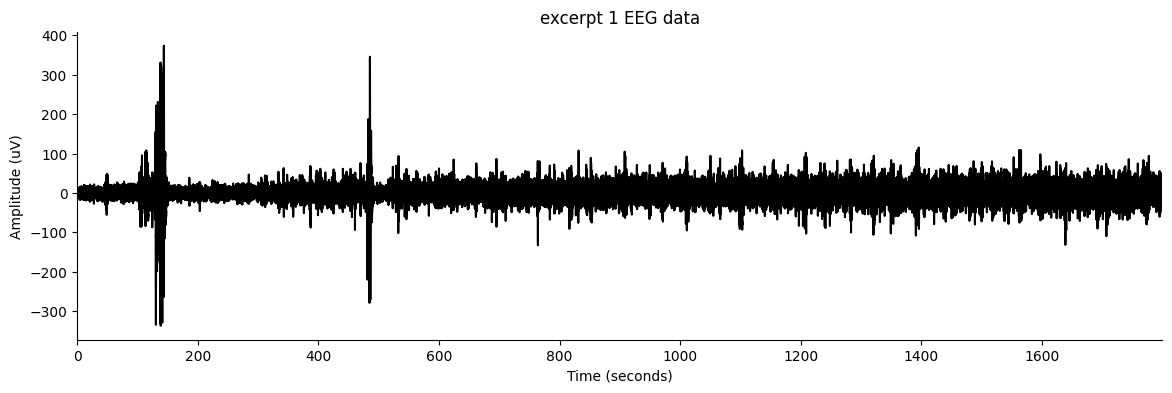

In [17]:
# %matplotlib widget

# Define sampling frequency and time vector
sf = 200.
times = np.arange(excerpt_signals[0].size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
plt.plot(times, excerpt_signals[0], lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('excerpt 1 EEG data')
sns.despine()

In [18]:
# Take the visual scoring for the first excerpt
visual_1 = df_visual.iloc[:,:2]
visual_1.dropna(inplace=True)
visual_1 = visual_1.values
visual_1.shape

(52, 2)

In [19]:
# create a boolean mask for the window of indices using np.zeros() and np.ones()
mask = np.zeros(excerpt_signals.shape[1], dtype=int)

for i in range(visual_1.shape[0]):
    start_index = int(visual_1[i][0]*sf)
    end_index = int(visual_1[i][0]*sf)+int(visual_1[i][1]*sf)
    mask[start_index:end_index] = 1

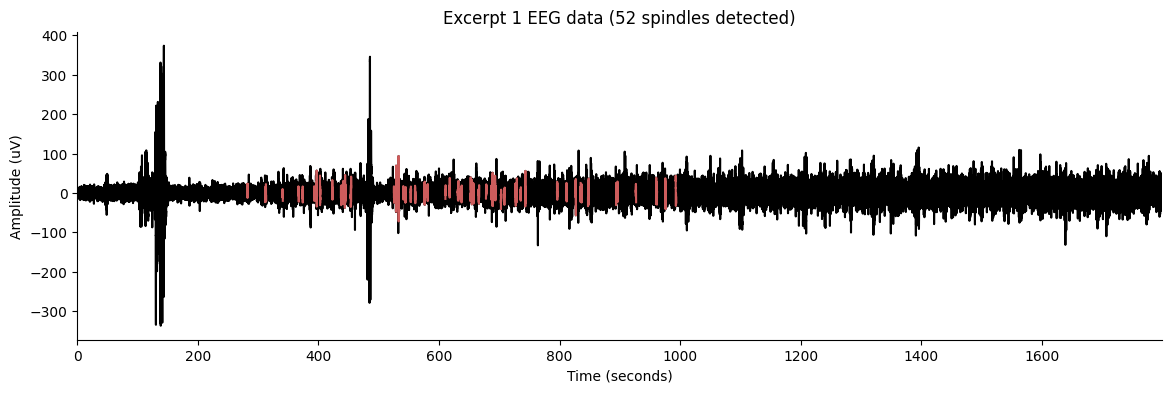

In [20]:
# Now let's plot
spindles_highlight = excerpt_signals[0] * mask
spindles_highlight[spindles_highlight == 0] = np.nan

plt.figure(figsize=(14, 4))
plt.plot(times, excerpt_signals[0], 'k')
plt.plot(times, spindles_highlight, 'indianred')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times[-1]])
plt.title('Excerpt 1 EEG data (52 spindles detected)')
sns.despine()
# plt.savefig('detection.png', dpi=300, bbox_inches='tight')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


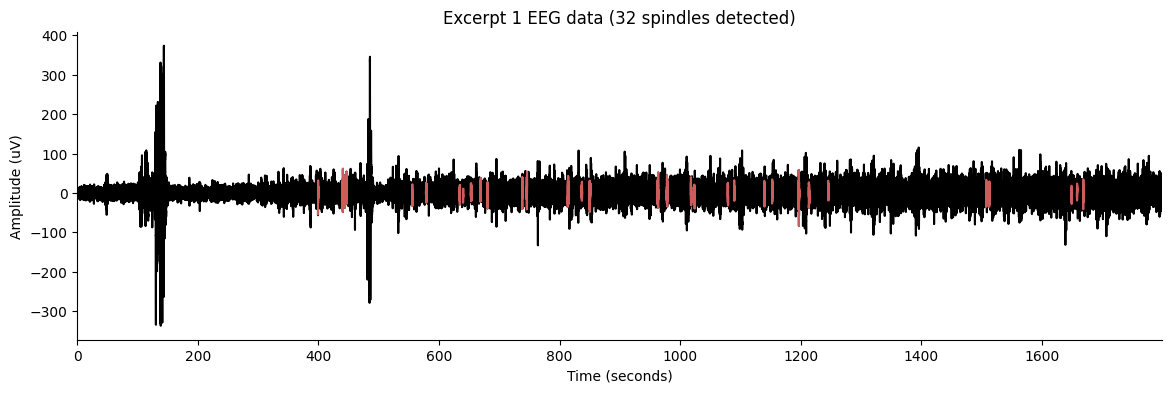

In [21]:
# Let's try to detect spindles using the YASA package and display the results
data = excerpt_signals[0]

sp = yasa.spindles_detect(data, sf)

# sp.summary()

mask = sp.get_mask()

# Now let's plot
spindles_highlight = data * mask
spindles_highlight[spindles_highlight == 0] = np.nan

plt.figure(figsize=(14, 4))
plt.plot(times, data, 'k')
plt.plot(times, spindles_highlight, 'indianred')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times[-1]])
plt.title(f'Excerpt 1 EEG data ({len(sp.summary())} spindles detected)')
sns.despine()

# Exctract features and labels

## Create masks for the visual spindles detection

In [22]:
# df_visual.iloc[:,:18].head(10)

In [23]:
df_visual_1 = df_visual.iloc[:,:16].copy()
df_visual_2 = df_visual.iloc[:,16:].copy()

In [24]:
# extract the spindeles position by the visual scoring of the first and second doctor
def spindles_positions(df_vis):
    spindles_positions = []
    # print(df_vis.shape)
    for i in range(0, df_vis.shape[1], 2):
        # print(df_vis.iloc[:,i-2:i])
        vis = df_vis.iloc[:,i:i+2]
        spindles_positions.append(vis.dropna().values)
    return spindles_positions

# visuals = []
# for i in range(0,16,2):
#     # print(df_visual.iloc[:,i-2:i])
#     vis = df_visual.iloc[:,i:i+2]
#     vis.dropna(inplace=True)
#     visuals.append(vis.values)
# len(visuals)
# [vis.shape for vis in visuals]
# type(visuals)


In [25]:
pos_1 = spindles_positions(df_visual_1)
pos_2 = spindles_positions(df_visual_2)
# [vis.shape for vis in pos_1]
# type(pos_1)


In [26]:
def create_mask(visual, sf, excerpt_signals):
    mask = np.zeros(excerpt_signals.shape[1], dtype=int)
    for i in range(visual.shape[0]):
        start_index = int(visual[i][0]*sf)
        end_index = int(visual[i][0]*sf)+int(visual[i][1]*sf)
        mask[start_index:end_index] = 1
    return mask

In [27]:
# masks = np.zeros(excerpt_signals.shape[0], dtype=int)
# masks = [create_mask(vis, sf, excerpt_signals) for vis in visuals]
# [m.sum() for m in masks]

In [28]:
masks_1 = np.zeros(excerpt_signals.shape[0], dtype=int)
masks_1 = [create_mask(vis, sf, excerpt_signals) for vis in pos_1]

masks_2 = np.zeros(excerpt_signals.shape[0], dtype=int)
masks_2 = [create_mask(vis, sf, excerpt_signals) for vis in pos_2]

# [m.sum() for m in masks_2]

## Features extraction

In [29]:
# Define number of patients
# -2 because we are not interested in samples from patients 7 and 8
NUM_PATIENTS = excerpt_signals.shape[0]-2

In [30]:
def extract_features(excerpt_signals, window_size=100, fs=200):
    # initialize an empty list to store the feature values
    feature_values = []
    
    # loop through each signal in excerpt_signals
    for i in range(NUM_PATIENTS):  
        signal = excerpt_signals[i, :]
        
        # calculate the total number of windows
        total_windows = signal.shape[0] // window_size

        # The second doctor did not score the last two excerpt, so we will ignore them
        if i == 6 or i == 7:
            v_mask_1 = masks_1[i]
            v_mask_2 = np.zeros(signal.shape[0], dtype=int)
        else:
            # extract the mask for the signal
            v_mask_1 = masks_1[i]
            v_mask_2 = masks_2[i]

        # use YASA to detect spindles
        sp = yasa.spindles_detect(data, sf)
        yasa_mask = sp.get_mask() if sp else np.zeros(signal.shape[0], dtype=int)

        # determine if a spindle occurs in the window using the masks of the two doctors and the YASA package
        spindles_visual_highlight_1 = signal * v_mask_1
        spindles_visual_highlight_2 = signal * v_mask_2
        spindles_visual_highlight_yasa = signal * yasa_mask
        
        # loop through each window in the signal
        for j in range(total_windows):
            # extract the window
            window = signal[j*window_size: (j+1)*window_size]
            
            if i == 6 or i == 7:
                spindle_in_window = 1 if (spindles_visual_highlight_1[j*window_size: (j+1)*window_size].sum()) > 10 else 0
            else:
                exp_1 = 1 if spindles_visual_highlight_1[j*window_size: (j+1)*window_size].sum() > 10 else 0
                exp_2 = 1 if spindles_visual_highlight_2[j*window_size: (j+1)*window_size].sum() > 10 else 0
                yasa_sp = 1 if spindles_visual_highlight_yasa[j*window_size: (j+1)*window_size].sum() > 10 else 0

                spindle_in_window = 1 if (np.array([exp_1, exp_2, yasa_sp]).sum()) >= 1 else 0
                
            # if spindle_in_window_v == 1:
            #     print(spindles_visual_highlight)
            #     print(spindle_in_window_v)

            # determine if a spindle occurs in the window using the YASA mask

            # spindle_in_window_yasa = 1 if (spindles_visual_highlight[j*window_size: (j+1)*window_size].sum()) > 1 else 0
            # if spindle_in_window_yasa == 1:
            #     print(spindles_visual_highlight)
            #     print(spindle_in_window_yasa)
            
            # compute sample entropy
            SpEn = nolds.sampen(window, emb_dim=2, tolerance=0.05*np.std(window))

            # compute maximum and minimum
            maximum = np.max(window)
            minimum = np.min(window)

            # compute variance and standard deviation
            variance = np.var(window)
            std_deviation = np.std(window)

            # compute phase amplitude coupling
            f, t, Sxx = spectrogram(window, fs=fs)
            PAC = np.sum(Sxx[11:17,:])/np.sum(Sxx)
        
            # compute instantaneous frequency
            inst_freq = np.mean(np.diff(np.unwrap(np.angle(hilbert(window)))))/(2*np.pi)

        
            # compute energy ratio (Energy11-16Hz)
            analytic_signal = hilbert(window)
            # calculate the amplitude of the analytic signal
            amplitude_envelope = np.abs(analytic_signal)
            # calculate the total energy of the input signal
            total_energy = np.sum(amplitude_envelope ** 2)
            # apply a bandpass filter to the amplitude envelope
            filtered_envelope = filter_signal(amplitude_envelope, 11, 16, fs, numtaps)
            # calculate the energy of the filtered signal
            spindle_energy = np.sum(filtered_envelope ** 2)
            energy_ratio = spindle_energy / total_energy
    
            # compute Power Spectral Density (PSD)
            f, Pxx = periodogram(window, fs=fs)

            # compute kurtosis and skewness
            kurt = kurtosis(Pxx)
            skewness = skew(Pxx)

            # compute power peak (PWRpeak)
            PWRpeak = np.max(Pxx)

            # compute power ratio (PWRratio)
            PWRratio = np.sum(Pxx[11:17])/np.sum(Pxx[:])

            # compute the empirical mode decomposition (EMD)
            decomposer = EMD()
            imfs = decomposer(window)
            # Extract the first mode from the IMFs
            mode_1 = imfs[0]
            
            # Compute the interquartile range (IQR) of the first mode
            q1, q3 = np.percentile(mode_1, [25, 75])
            IQR = q3 - q1

            # Compute zero crossing
            zero_crossing = len(np.where(np.diff(np.sign(mode_1)))[0])

            # Determine the patient id for future patient discimination
            patient_id = i+1
            
            # Append the computed feature values to the list
            feature_values.append([spindle_in_window, patient_id, SpEn, maximum, minimum, variance, std_deviation, PAC, inst_freq, energy_ratio,
                                   kurt, skewness, PWRpeak, PWRratio, IQR, zero_crossing])

    # create a pandas dataframe from the list of feature values
    feature_df = pd.DataFrame(feature_values, columns=['is_spindle', 'patient_id', 'SpEn', 'maximum', 'minimum', 'variance', 'std_deviation', 
                                                       'PAC', 'inst_freq', 'energy_ratio', 'kurt', 'skewness', 
                                                       'PWRpeak', 'PWRratio', 'IQR', 'zero_crossing'])

    return feature_df

In [31]:
def extract_features_sliding_windows(excerpt_signals, window_size=20, fs=200):
    # initialize an empty list to store the feature values
    feature_values = []

    # loop through each signal in excerpt_signals
    for i in range(NUM_PATIENTS):

        signal = excerpt_signals[i, :]
        
        # calculate the total number of windows
        total_windows = signal.shape[0] // window_size

        # The second doctor did not score the last two excerpt, so we will ignore them
        if i == 6 or i == 7:
            v_mask_1 = masks_1[i]
            v_mask_2 = np.zeros(signal.shape[0], dtype=int)
        else:
            # extract the mask for the signal
            v_mask_1 = masks_1[i]
            v_mask_2 = masks_2[i]

        # use YASA to detect spindles
        sp = yasa.spindles_detect(data, sf)
        yasa_mask = sp.get_mask() if sp else np.zeros(signal.shape[0], dtype=int)

        # determine if a spindle occurs in the window using the masks of the two doctors and the YASA package
        spindles_visual_highlight_1 = signal * v_mask_1
        spindles_visual_highlight_2 = signal * v_mask_2
        spindles_visual_highlight_yasa = signal * yasa_mask
        
        # loop through each window in the signal
        for j in range(total_windows):
            # extract the window
            # if j == 0:
            #     window = signal[j*window_size: (j+5)*window_size]
            #     start, end = j*window_size, (j+5)*window_size
            # elif (j+5) > total_windows:
            #     continue
            # else:
            #     window = signal[j*window_size: (j+5)*(window_size)]
            #     start, end = j*window_size, (j+5)*(window_size)

            if (j+5) > total_windows:
                continue
            else:
                window = signal[j*window_size: (j+5)*(window_size)]
                start, end = j*window_size, (j+5)*(window_size)
            
            if i == 6 or i == 7:
                spindle_in_window = 1 if (spindles_visual_highlight_1[start:end].sum()) > 5 else 0
            else:
                exp_1 = 1 if spindles_visual_highlight_1[start:end].sum() > 5 else 0
                exp_2 = 1 if spindles_visual_highlight_2[start:end].sum() > 5 else 0
                yasa_sp = 1 if spindles_visual_highlight_yasa[start:end].sum() > 5 else 0

                spindle_in_window = 1 if (np.array([exp_1, exp_2, yasa_sp]).sum()) >= 1 else 0
                
            # if spindle_in_window_v == 1:
            #     print(spindles_visual_highlight)
            #     print(spindle_in_window_v)

            # determine if a spindle occurs in the window using the YASA mask

            # spindle_in_window_yasa = 1 if (spindles_visual_highlight[j*window_size: (j+1)*window_size].sum()) > 1 else 0
            # if spindle_in_window_yasa == 1:
            #     print(spindles_visual_highlight)
            #     print(spindle_in_window_yasa)
            
            # compute sample entropy
            SpEn = nolds.sampen(window, emb_dim=2, tolerance=0.05*np.std(window))

            # compute maximum and minimum
            maximum = np.max(window)
            minimum = np.min(window)

            # compute variance and standard deviation
            variance = np.var(window)
            std_deviation = np.std(window)

            # compute phase amplitude coupling
            f, t, Sxx = spectrogram(window, fs=fs)
            PAC = np.sum(Sxx[11:17,:])/np.sum(Sxx)
        
            # compute instantaneous frequency
            inst_freq = np.mean(np.diff(np.unwrap(np.angle(hilbert(window)))))/(2*np.pi)

        
            # compute energy ratio (Energy11-16Hz)
            analytic_signal = hilbert(window)
            # calculate the amplitude of the analytic signal
            amplitude_envelope = np.abs(analytic_signal)
            # calculate the total energy of the input signal
            total_energy = np.sum(amplitude_envelope ** 2)
            # apply a bandpass filter to the amplitude envelope
            filtered_envelope = filter_signal(amplitude_envelope, 11, 16, fs, numtaps)
            # calculate the energy of the filtered signal
            spindle_energy = np.sum(filtered_envelope ** 2)
            energy_ratio = spindle_energy / total_energy
    
            # compute Power Spectral Density (PSD)
            f, Pxx = periodogram(window, fs=fs)

            # compute kurtosis and skewness
            kurt = kurtosis(Pxx)
            skewness = skew(Pxx)

            # compute power peak (PWRpeak)
            PWRpeak = np.max(Pxx)

            # compute power ratio (PWRratio)
            PWRratio = np.sum(Pxx[11:17])/np.sum(Pxx[:])

            # compute the empirical mode decomposition (EMD)
            decomposer = EMD()
            imfs = decomposer(window)
            # Extract the first mode from the IMFs
            mode_1 = imfs[0]
            
            # Compute the interquartile range (IQR) of the first mode
            q1, q3 = np.percentile(mode_1, [25, 75])
            IQR = q3 - q1

            # Compute zero crossing
            zero_crossing = len(np.where(np.diff(np.sign(mode_1)))[0])

            # Determine the patient id for future patient discimination
            patient_id = i+1
            
            # Append the computed feature values to the list
            feature_values.append([spindle_in_window, patient_id, SpEn, maximum, minimum, variance, std_deviation, PAC, inst_freq, energy_ratio,
                                   kurt, skewness, PWRpeak, PWRratio, IQR, zero_crossing])

    # create a pandas dataframe from the list of feature values
    feature_df = pd.DataFrame(feature_values, columns=['is_spindle', 'patient_id', 'SpEn', 'maximum', 'minimum', 'variance', 'std_deviation', 
                                                       'PAC', 'inst_freq', 'energy_ratio', 'kurt', 'skewness', 
                                                       'PWRpeak', 'PWRratio', 'IQR', 'zero_crossing'])

    return feature_df

We are not extracting features from patients 7 and 8 beacuse we have just the opinion from doctor 1 for their spindle detection. 

Both doctor 2 and YASA doesn't find spindles in their samples, so we prefer to just remove them from our data. 

We are also losing just 86 spindles over a total of 1116, so it is not a problem.

In [32]:
df_features = extract_features(excerpt_signals)
df_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [ ]:
df_features.is_spindle.sum()

1055

In [ ]:
# Count infinite values in SpEn feature
print('infinites in SpEn:', df_features.SpEn.loc[df_features['SpEn'] == np.inf].count())

infinites in SpEn: 905


In [ ]:
# Get the maximum value besides infinite in SpEn
print('Get maximum value besides SpEn:', df_features.SpEn.loc[df_features['SpEn'] != np.inf].max())

Get maximum value besides SpEn: 3.1780538303479458


In [ ]:
# Cap the infinites to the maximum values besides it
df_features.loc[df_features['SpEn'] == np.inf, 'SpEn'] = df_features.SpEn.loc[df_features['SpEn'] != np.inf].max()

In [ ]:
# Check for null values created by mistake
df_features.isna().sum()

is_spindle       0
patient_id       0
SpEn             0
maximum          0
minimum          0
variance         0
std_deviation    0
PAC              0
inst_freq        0
energy_ratio     0
kurt             0
skewness         0
PWRpeak          0
PWRratio         0
IQR              0
zero_crossing    0
dtype: int64

In [ ]:
df_sw = extract_features_sliding_windows(excerpt_signals)
df_sw

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

,is_spindle,patient_id,SpEn,maximum,minimum,variance,std_deviation,PAC,inst_freq,energy_ratio,kurt,skewness,PWRpeak,PWRratio,IQR,zero_crossing
0,0,1,3.091042,-4.868705e-05,-7.753086e-03,3.454844e-06,1.858721e-03,0.004164,-0.001094,8.424509e-08,40.081961,6.329113,1.094418e-06,0.014988,5.618675e-04,31
1,0,1,2.197225,-1.113577e-03,-7.753086e-03,2.418575e-06,1.555177e-03,0.012227,-0.000350,8.407336e-08,44.274981,6.746495,9.194249e-07,0.009022,5.982615e-04,36
2,0,1,2.036882,1.546885e-03,-7.753086e-03,5.552298e-06,2.356331e-03,0.008369,0.019868,1.042858e-07,44.627129,6.785429,2.271715e-06,0.011423,7.865235e-04,35
3,0,1,2.708050,2.805458e-03,-7.753086e-03,8.240334e-06,2.870598e-03,0.004611,0.029068,2.189754e-07,43.159392,6.633907,2.790490e-06,0.016698,8.339972e-04,35
4,0,1,1.945910,5.426219e-03,-6.362570e-03,9.929350e-06,3.151087e-03,0.005519,0.019078,2.879230e-07,29.309098,5.383276,2.440607e-06,0.039591,1.027452e-03,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107971,0,6,1.308333,3.642684e+07,-1.941036e+07,1.134979e+14,1.065354e+07,0.011061,0.019061,1.111728e-07,15.819074,4.004640,1.995476e+13,0.015018,6.317623e+06,16
107972,0,6,1.312186,4.324890e+07,-1.941036e+07,2.253145e+14,1.501048e+07,0.004250,0.019686,1.533074e-07,41.888716,6.503003,7.774635e+13,0.005540,8.993379e+06,16
107973,0,6,0.961411,4.324890e+07,-1.941036e+07,2.796973e+14,1.672415e+07,0.006146,0.009395,3.903300e-07,41.711423,6.479457,9.182575e+13,0.006765,1.028744e+07,19
107974,0,6,1.049822,4.324890e+07,-1.941036e+07,2.322327e+14,1.523918e+07,0.014913,0.009039,2.231807e-07,21.953038,4.546364,4.623511e+13,0.014144,7.163961e+06,22


In [ ]:
df_sw.is_spindle.sum()

5329

In [ ]:
# Count infinite values in SpEn feature
print('infinites in SpEn:', df_sw.SpEn.loc[df_sw['SpEn'] == np.inf].count())

infinites in SpEn: 4582


In [ ]:
# Get the maximum value besides infinite in SpEn
print('Get maximum value besides SpEn:', df_sw.SpEn.loc[df_sw['SpEn'] != np.inf].max())

Get maximum value besides SpEn: 3.258096538021482


In [ ]:
# Cap the infinites to the maximum values besides it
df_sw.loc[df_sw['SpEn'] == np.inf, 'SpEn'] = df_sw.SpEn.loc[df_sw['SpEn'] != np.inf].max()

In [ ]:
# Check for null values created by mistake
df_sw.isna().sum()

is_spindle       0
patient_id       0
SpEn             0
maximum          0
minimum          0
variance         0
std_deviation    0
PAC              0
inst_freq        0
energy_ratio     0
kurt             0
skewness         0
PWRpeak          0
PWRratio         0
IQR              0
zero_crossing    0
dtype: int64

# Train-test split

We want to have about 50% of spindles in the training set, 30% spindles in the testing set, and 20% spindles in the validation set.
We'll split patients between sets accordingly, so to not have patients' data divided into different sets.

## Using dataset without overlaps



In [ ]:
# Check the number of spindles for each patient in the dataset
for i in range(NUM_PATIENTS):
    print('Patient', i+1)
    print('Number of samples:', df_features.loc[df_features['patient_id'] == i+1].shape[0])
    temp = df_features.loc[df_features['patient_id'] == i+1]
    num_spindles = temp['is_spindle'].sum()
    print('Number of spindles:', num_spindles)
    print('-'*20)

Patient 1
Number of samples: 3600
Number of spindles: 238
--------------------
Patient 2
Number of samples: 3600
Number of spindles: 147
--------------------
Patient 3
Number of samples: 3600
Number of spindles: 108
--------------------
Patient 4
Number of samples: 3600
Number of spindles: 128
--------------------
Patient 5
Number of samples: 3600
Number of spindles: 205
--------------------
Patient 6
Number of samples: 3600
Number of spindles: 229
--------------------


In [ ]:
# We want 50% of spindles in the training set, 30% of the spindles in the testing set and 20% of the spindles in the validation set
print('Total number of spindles:', df_features[df_features['is_spindle'] == 1].shape[0])
print('Number of spindles to have 50% of the spindles:', int(df_features[df_features['is_spindle'] == 1].shape[0]*0.5))
print('Number of spindles to have 30% of the spindles:', int(df_features[df_features['is_spindle'] == 1].shape[0]*0.3))
print('Number of spindles to have 20% of the spindles:', int(df_features[df_features['is_spindle'] == 1].shape[0]*0.2))

Total number of spindles: 1055
Number of spindles to have 50% of the spindles: 527
Number of spindles to have 30% of the spindles: 316
Number of spindles to have 20% of the spindles: 211


In [ ]:
# Get ~50% of the spindles by taking patients 1 and 6 in the training set
df_train = df_features[df_features['patient_id'].isin([1, 6])]
df_train

,is_spindle,patient_id,SpEn,maximum,minimum,variance,std_deviation,PAC,inst_freq,energy_ratio,kurt,skewness,PWRpeak,PWRratio,IQR,zero_crossing
0,0,1,3.091042,-4.868705e-05,-7.753086e-03,3.454844e-06,1.858721e-03,0.004164,-0.001094,8.424509e-08,40.081961,6.329113,1.094418e-06,0.014988,5.618675e-04,31
1,0,1,3.178054,5.689756e-03,-5.422475e-03,7.894295e-06,2.809679e-03,0.012282,0.018894,2.443162e-07,34.898821,5.871523,2.217601e-06,0.013342,1.243414e-03,34
2,0,1,0.597227,7.481033e-02,2.823563e-03,4.841402e-04,2.200319e-02,0.000234,-0.000992,1.662477e-07,42.200411,6.536089,1.593872e-04,0.022406,1.622183e-03,35
3,0,1,1.791759,1.778605e-01,7.482668e-02,8.181524e-04,2.860336e-02,0.000660,-0.000665,8.798987e-08,38.475203,6.183382,2.402906e-04,0.020090,3.979508e-03,35
4,0,1,0.536305,1.818140e-01,-3.264030e-02,2.101107e-03,4.583784e-02,0.003454,-0.001320,1.426887e-07,40.517885,6.372533,5.949377e-04,0.051021,7.360702e-03,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21595,0,6,0.998529,2.094489e+07,-3.569562e+07,2.286229e+14,1.512028e+07,0.003185,0.030598,9.556183e-08,21.404486,4.559362,5.096866e+13,0.003282,1.125520e+07,15
21596,0,6,0.606136,3.287438e+07,-3.014608e+07,3.294393e+14,1.815046e+07,0.006167,0.009239,9.235026e-08,39.486490,6.297664,1.143674e+14,0.005965,4.393623e+06,21
21597,0,6,0.804373,3.510685e+07,-2.581705e+07,2.217440e+14,1.489107e+07,0.006721,0.019018,2.539020e-07,13.573237,3.693109,3.516905e+13,0.030392,1.051285e+07,14
21598,0,6,1.481605,1.815958e+07,-1.941036e+07,6.223977e+13,7.889219e+06,0.024837,0.019746,1.625233e-07,17.154179,4.165170,1.147758e+13,0.026314,3.937557e+06,20


In [ ]:
# Get ~30% of the spindles by taking patients 3, 5 in the testing set
df_test = df_features[df_features['patient_id'].isin([3, 5])]
df_test

,is_spindle,patient_id,SpEn,maximum,minimum,variance,std_deviation,PAC,inst_freq,energy_ratio,kurt,skewness,PWRpeak,PWRratio,IQR,zero_crossing
7200,0,3,2.397895,1.183822e-02,5.693564e-04,7.891607e-06,2.809200e-03,0.015571,-0.001185,7.683931e-08,22.282956,4.554082,1.486310e-06,0.012765,1.065316e-03,35
7201,0,3,2.079442,9.449746e-03,-4.571577e-02,2.337958e-04,1.529038e-02,0.002090,0.029086,2.204172e-07,42.001297,6.512952,7.394488e-05,0.013508,3.696097e-03,35
7202,0,3,3.178054,-3.793065e-02,-1.144225e-01,4.796965e-04,2.190197e-02,0.003858,-0.000442,8.371957e-08,43.660738,6.683122,1.670682e-04,0.031397,1.050633e-02,35
7203,0,3,2.014903,5.268750e-02,-1.094077e-01,1.564606e-03,3.955509e-02,0.010331,0.019347,1.680890e-07,34.843169,5.810267,3.875944e-04,0.054637,2.666889e-02,35
7204,0,3,1.760988,4.375647e+00,-4.807616e-01,2.237357e-01,4.730071e-01,0.050692,0.007915,1.924832e-07,7.134842,2.642795,9.993578e-03,0.109495,9.189734e-02,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,0,5,0.639080,3.332452e+07,-4.054400e+07,2.898519e+14,1.702504e+07,0.003675,0.008825,8.376065e-08,43.304339,6.643511,1.033715e+14,0.008842,4.664308e+06,16
17996,0,5,0.580669,3.799797e+07,-4.531970e+07,5.453996e+14,2.335379e+07,0.001078,0.009059,1.951771e-07,45.495493,6.874021,2.384988e+14,0.009392,2.212549e+06,21
17997,0,5,0.550046,1.997601e+07,-3.070015e+07,2.807564e+14,1.675579e+07,0.001501,0.009831,1.749636e-07,45.294807,6.852678,1.229078e+14,0.001476,3.999905e+06,19
17998,0,5,0.435318,5.778881e+07,-1.207360e+07,4.917131e+14,2.217460e+07,0.001498,0.009090,1.010171e-07,44.428383,6.765195,1.983196e+14,0.013210,3.136841e+06,18


In [ ]:
# Get ~20% of the spindles by taking patients 2 and 4 in the validation set
df_val = df_features[df_features['patient_id'].isin([2, 4])]
df_val

,is_spindle,patient_id,SpEn,maximum,minimum,variance,std_deviation,PAC,inst_freq,energy_ratio,kurt,skewness,PWRpeak,PWRratio,IQR,zero_crossing
3600,0,2,0.727049,7.404030e-03,-3.634052e-02,1.803094e-04,1.342793e-02,0.000192,0.009411,7.937881e-08,45.952840,6.922316,8.582571e-05,0.001429,5.222706e-04,35
3601,0,2,0.257829,6.859062e-02,-2.170186e-02,8.631947e-04,2.938018e-02,0.000130,0.009033,2.055519e-07,43.793255,6.699962,3.242439e-04,0.013091,8.228871e-04,32
3602,1,2,0.413187,1.666572e-01,6.887743e-02,1.064827e-03,3.263169e-02,0.000074,-0.000675,9.357859e-08,42.918189,6.610158,3.707100e-04,0.016728,1.424684e-03,34
3603,0,2,0.614010,1.702832e-01,5.603042e-02,1.235950e-03,3.515608e-02,0.000267,-0.000764,1.323520e-07,42.400211,6.556432,4.139098e-04,0.018835,2.295780e-03,35
3604,0,2,0.906721,4.949773e-02,-8.213632e-01,1.436364e-02,1.198484e-01,0.008826,-0.001940,2.251566e-07,41.161567,6.436461,3.067294e-03,0.039600,1.215540e-02,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14395,0,4,2.639057,1.629705e+07,-1.008893e+08,6.610993e+14,2.571185e+07,0.275456,0.029614,1.827057e-07,10.361134,3.126679,7.701686e+13,0.263502,2.448187e+07,26
14396,0,4,3.178054,6.246698e+07,-3.932329e+07,4.219712e+14,2.054194e+07,0.118986,0.028807,2.140193e-07,15.998952,3.980534,6.041305e+13,0.090462,1.391785e+07,27
14397,0,4,2.197225,1.374854e+08,-1.809127e+08,4.646508e+15,6.816530e+07,0.054058,0.028834,1.692187e-07,24.672342,4.859805,1.032219e+15,0.053109,3.660369e+07,22
14398,0,4,1.203973,8.353917e+07,-8.726891e+07,1.578066e+15,3.972488e+07,0.024442,0.029313,1.792393e-07,12.578343,3.616590,2.257873e+14,0.021821,2.323885e+07,18


### Check data balancing

In [ ]:
# Plot the dataset balancing
def plot_dataset_balancing(df_train, df_test, df_val=None) -> None:
        # Calculate the counts for train set
        train_positive_count = df_train['is_spindle'].sum()
        train_negative_count = len(df_train) - train_positive_count

        # Calculate the counts for test set
        test_positive_count = df_test['is_spindle'].sum()
        test_negative_count = len(df_test) - test_positive_count

        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        # Train set pie chart
        train_labels = ['Spindles', 'Not Spindles']
        train_sizes = [train_positive_count, train_negative_count]
        train_colors = ['#ff9999', '#66b3ff']
        train_explode = (0.1, 0)

        ax1.pie(train_sizes, labels=train_labels, colors=train_colors, explode=train_explode,
                autopct='%1.1f%%', startangle=90)
        ax1.set_title('Train Set')

        # Test set pie chart
        test_labels = ['Spindles', 'Not Spindles']
        test_sizes = [test_positive_count, test_negative_count]
        test_colors = ['#ff9999', '#66b3ff']
        test_explode = (0.1, 0)

        ax2.pie(test_sizes, labels=test_labels, colors=test_colors, explode=test_explode,
                autopct='%1.1f%%', startangle=90)
        ax2.set_title('Test Set')

        ax1.axis('equal')
        ax2.axis('equal')
        fig.suptitle('Dataset Balance', fontsize=16)

        plt.show()

In [ ]:
# Plot the dataset balancing
def plot_dataset_balancing(df_train, df_test, df_val=None) -> None:
        # Calculate the counts for train set
        train_positive_count = df_train['is_spindle'].sum()
        train_negative_count = len(df_train) - train_positive_count

        # Calculate the counts for test set
        test_positive_count = df_test['is_spindle'].sum()
        test_negative_count = len(df_test) - test_positive_count

        # Create a figure with two or three subplots
        if df_val is not None:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        # Train set pie chart
        train_labels = ['Spindles', 'Not Spindles']
        train_sizes = [train_positive_count, train_negative_count]
        train_colors = ['#ff9999', '#66b3ff']
        train_explode = (0.1, 0)

        ax1.pie(train_sizes, labels=train_labels, colors=train_colors, explode=train_explode,
                autopct='%1.1f%%', startangle=90)
        ax1.set_title('Train Set')

        # Test set pie chart
        test_labels = ['Spindles', 'Not Spindles']
        test_sizes = [test_positive_count, test_negative_count]
        test_colors = ['#ff9999', '#66b3ff']
        test_explode = (0.1, 0)

        ax2.pie(test_sizes, labels=test_labels, colors=test_colors, explode=test_explode,
                autopct='%1.1f%%', startangle=90)
        ax2.set_title('Test Set')

        # Val set pie chart (if df_val is not None)
        if df_val is not None:
            val_positive_count = df_val['is_spindle'].sum()
            val_negative_count = len(df_val) - val_positive_count

            val_labels = ['Spindles', 'Not Spindles']
            val_sizes = [val_positive_count, val_negative_count]
            val_colors = ['#ff9999', '#66b3ff']
            val_explode = (0.1, 0)

            ax3.pie(val_sizes, labels=val_labels, colors=val_colors, explode=val_explode,
                    autopct='%1.1f%%', startangle=90)
            ax3.set_title('Validation Set')

        ax1.axis('equal')
        ax2.axis('equal')

        # Set the layout based on the number of subplots
        if df_val is not None:
            fig.suptitle('Dataset Balance (Train/Test/Val)', fontsize=16)
            fig.tight_layout(pad=3.0)
        else:
            fig.suptitle('Dataset Balance (Train/Test)', fontsize=16)
            fig.tight_layout()

        plt.show()


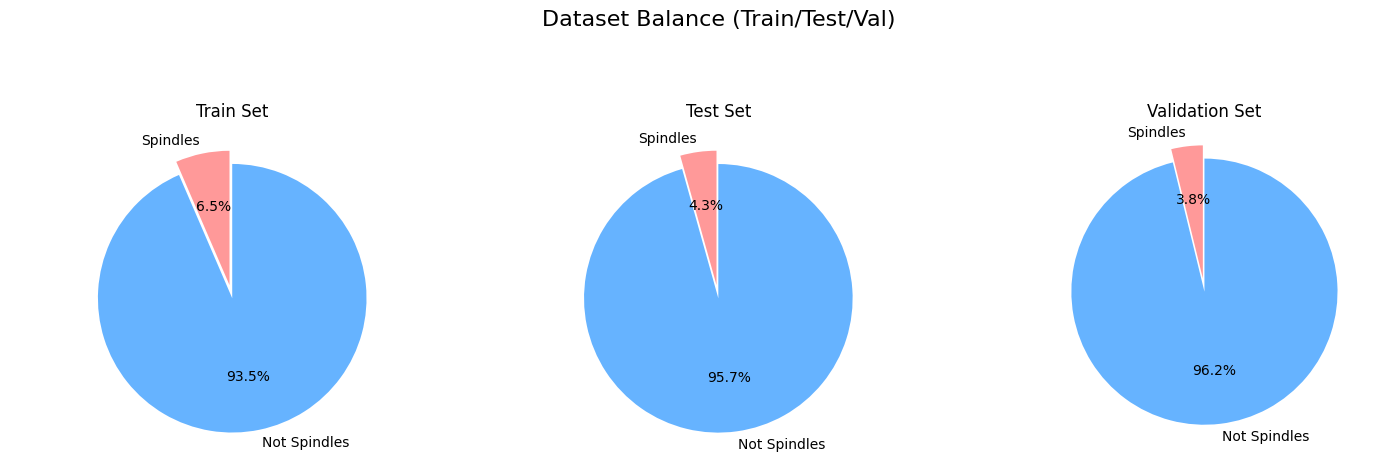

In [ ]:
# Check initial datasets balancing
plot_dataset_balancing(df_train, df_test, df_val)

## Using dataset with overlapping windows

In [ ]:
# Check the number of spindles for each patient in the dataset
for i in range(NUM_PATIENTS):
    print('Patient', i+1)
    print('Number of samples:', df_sw.loc[df_sw['patient_id'] == i+1].shape[0])
    temp = df_sw.loc[df_sw['patient_id'] == i+1]
    num_spindles = temp['is_spindle'].sum()
    print('Number of spindles:', num_spindles)
    print('-'*20)

Patient 1
Number of samples: 17996
Number of spindles: 1227
--------------------
Patient 2
Number of samples: 17996
Number of spindles: 773
--------------------
Patient 3
Number of samples: 17996
Number of spindles: 544
--------------------
Patient 4
Number of samples: 17996
Number of spindles: 659
--------------------
Patient 5
Number of samples: 17996
Number of spindles: 998
--------------------
Patient 6
Number of samples: 17996
Number of spindles: 1128
--------------------


In [ ]:
# We want 50% of spindles in the training set, 30% of the spindles in the testing set and 20% of the spindles in the validation set
# To have the numbers nearest to there ratios, we would put patients 1 and 6 in train, 2 and 5 in test and 4 and 4 in validatio. 
# to keep consistent the evaluation with the dataset with no overlaps, we will put patients 1 and 6 in train, 3 and 5 in test and 2 and 4 in validation, as used in the dataset with no overlaps
print('Total number of spindles:', df_sw[df_sw['is_spindle'] == 1].shape[0])
print('Number of spindles to have 50% of the spindles:', int(df_sw[df_sw['is_spindle'] == 1].shape[0]*0.5))
print('Number of spindles to have 30% of the spindles:', int(df_sw[df_sw['is_spindle'] == 1].shape[0]*0.3))
print('Number of spindles to have 20% of the spindles:', int(df_sw[df_sw['is_spindle'] == 1].shape[0]*0.2)) 

Total number of spindles: 5329
Number of spindles to have 50% of the spindles: 2664
Number of spindles to have 30% of the spindles: 1598
Number of spindles to have 20% of the spindles: 1065


In [ ]:
# Get ~50% of the spindles by taking patients 1 and 6 in the training set
df_train_sw = df_sw[df_sw['patient_id'].isin([1, 6])]
df_train_sw

,is_spindle,patient_id,SpEn,maximum,minimum,variance,std_deviation,PAC,inst_freq,energy_ratio,kurt,skewness,PWRpeak,PWRratio,IQR,zero_crossing
0,0,1,3.091042,-4.868705e-05,-7.753086e-03,3.454844e-06,1.858721e-03,0.004164,-0.001094,8.424509e-08,40.081961,6.329113,1.094418e-06,0.014988,5.618675e-04,31
1,0,1,2.197225,-1.113577e-03,-7.753086e-03,2.418575e-06,1.555177e-03,0.012227,-0.000350,8.407336e-08,44.274981,6.746495,9.194249e-07,0.009022,5.982615e-04,36
2,0,1,2.036882,1.546885e-03,-7.753086e-03,5.552298e-06,2.356331e-03,0.008369,0.019868,1.042858e-07,44.627129,6.785429,2.271715e-06,0.011423,7.865235e-04,35
3,0,1,2.708050,2.805458e-03,-7.753086e-03,8.240334e-06,2.870598e-03,0.004611,0.029068,2.189754e-07,43.159392,6.633907,2.790490e-06,0.016698,8.339972e-04,35
4,0,1,1.945910,5.426219e-03,-6.362570e-03,9.929350e-06,3.151087e-03,0.005519,0.019078,2.879230e-07,29.309098,5.383276,2.440607e-06,0.039591,1.027452e-03,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107971,0,6,1.308333,3.642684e+07,-1.941036e+07,1.134979e+14,1.065354e+07,0.011061,0.019061,1.111728e-07,15.819074,4.004640,1.995476e+13,0.015018,6.317623e+06,16
107972,0,6,1.312186,4.324890e+07,-1.941036e+07,2.253145e+14,1.501048e+07,0.004250,0.019686,1.533074e-07,41.888716,6.503003,7.774635e+13,0.005540,8.993379e+06,16
107973,0,6,0.961411,4.324890e+07,-1.941036e+07,2.796973e+14,1.672415e+07,0.006146,0.009395,3.903300e-07,41.711423,6.479457,9.182575e+13,0.006765,1.028744e+07,19
107974,0,6,1.049822,4.324890e+07,-1.941036e+07,2.322327e+14,1.523918e+07,0.014913,0.009039,2.231807e-07,21.953038,4.546364,4.623511e+13,0.014144,7.163961e+06,22


In [ ]:
# Get ~30% of the spindles by taking patients 3 and 5 in the testing set
df_test_sw = df_sw[df_sw['patient_id'].isin([3, 5])]
df_test_sw

,is_spindle,patient_id,SpEn,maximum,minimum,variance,std_deviation,PAC,inst_freq,energy_ratio,kurt,skewness,PWRpeak,PWRratio,IQR,zero_crossing
35992,0,3,2.397895,1.183822e-02,5.693564e-04,7.891607e-06,2.809200e-03,0.015571,-0.001185,7.683931e-08,22.282956,4.554082,1.486310e-06,0.012765,1.065316e-03,35
35993,0,3,1.945910,1.183822e-02,-4.595290e-04,7.092824e-06,2.663236e-03,0.018271,0.005694,6.744244e-08,40.807553,6.388313,2.164205e-06,0.014987,1.411429e-03,34
35994,0,3,1.704748,1.183822e-02,-3.303916e-03,1.498460e-05,3.870995e-03,0.008551,0.009376,1.306454e-07,26.316818,5.114564,3.485551e-06,0.036272,1.844541e-03,35
35995,0,3,2.302585,1.162116e-02,-1.706707e-02,3.031645e-05,5.506038e-03,0.006114,0.008516,1.628477e-07,44.157662,6.731488,1.004432e-05,0.012802,2.193306e-03,35
35996,0,3,3.044522,1.162116e-02,-3.034385e-02,1.323123e-04,1.150271e-02,0.001400,0.009182,2.150942e-07,27.525178,5.246320,3.451482e-05,0.025139,2.835328e-03,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89975,0,5,0.421726,5.778881e+07,-1.207360e+07,4.523110e+14,2.126760e+07,0.001860,0.009357,7.818927e-08,45.845032,6.910663,2.091106e+14,0.003364,2.561270e+06,20
89976,0,5,0.674798,5.778881e+07,-1.207360e+07,3.932277e+14,1.982997e+07,0.002079,0.008921,1.236750e-07,16.237613,4.137825,7.018787e+13,0.015823,2.322056e+06,21
89977,0,5,0.810930,5.778881e+07,1.615581e+07,1.985293e+14,1.409004e+07,0.002683,0.000429,6.823218e-08,39.767168,6.301642,6.794218e+13,0.002958,3.631232e+06,16
89978,0,5,0.557806,5.627133e+07,1.590160e+07,2.239233e+14,1.496407e+07,0.001930,-0.000820,1.357607e-07,45.933897,6.920272,1.019772e+14,0.022024,2.594653e+06,19


In [ ]:
# Get ~20% of the spindles by taking patients 2 and 4 in the validation set
df_val_sw = df_sw[df_sw['patient_id'].isin([2, 4])]
df_val_sw

,is_spindle,patient_id,SpEn,maximum,minimum,variance,std_deviation,PAC,inst_freq,energy_ratio,kurt,skewness,PWRpeak,PWRratio,IQR,zero_crossing
17996,0,2,0.727049,7.404030e-03,-3.634052e-02,1.803094e-04,1.342793e-02,0.000192,0.009411,7.937881e-08,45.952840,6.922316,8.582571e-05,0.001429,5.222706e-04,35
17997,0,2,1.122143,7.404030e-03,-3.634052e-02,1.461212e-04,1.208806e-02,0.000225,0.009001,1.145440e-07,41.962228,6.518770,5.212703e-05,0.010938,7.337591e-04,35
17998,0,2,0.925769,-5.622395e-03,-3.634052e-02,5.552958e-05,7.451817e-03,0.000461,-0.000658,6.451952e-08,25.947684,5.166539,1.605139e-05,0.005319,7.186061e-04,34
17999,0,2,0.681451,1.264978e-02,-3.634052e-02,1.170574e-04,1.081931e-02,0.000304,0.008936,1.508859e-07,35.806248,5.933634,3.389171e-05,0.018435,7.743131e-04,32
18000,0,2,0.480815,4.185999e-02,-3.384025e-02,3.464120e-04,1.861215e-02,0.000462,0.008780,2.862602e-07,35.060408,5.832679,8.640134e-05,0.030884,8.538616e-04,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71979,0,4,1.003302,8.353917e+07,-8.726891e+07,1.499988e+15,3.872968e+07,0.018967,0.018838,2.673350e-07,19.970929,4.321534,2.807500e+14,0.027219,1.860306e+07,18
71980,0,4,1.252763,5.841781e+07,-8.726891e+07,1.098498e+15,3.314360e+07,0.018022,0.029372,3.066468e-07,31.834246,5.534972,2.904395e+14,0.015448,1.872366e+07,18
71981,0,4,1.134980,7.010570e+07,-4.568307e+07,9.985833e+14,3.160037e+07,0.024057,0.029043,1.164283e-07,9.121376,3.197574,1.241148e+14,0.030875,1.402211e+07,19
71982,0,4,1.232144,7.010570e+07,-3.404326e+07,8.880095e+14,2.979949e+07,0.015511,0.018653,1.077419e-07,38.599329,6.187535,2.712384e+14,0.021855,1.418805e+07,19


### Check data balancing

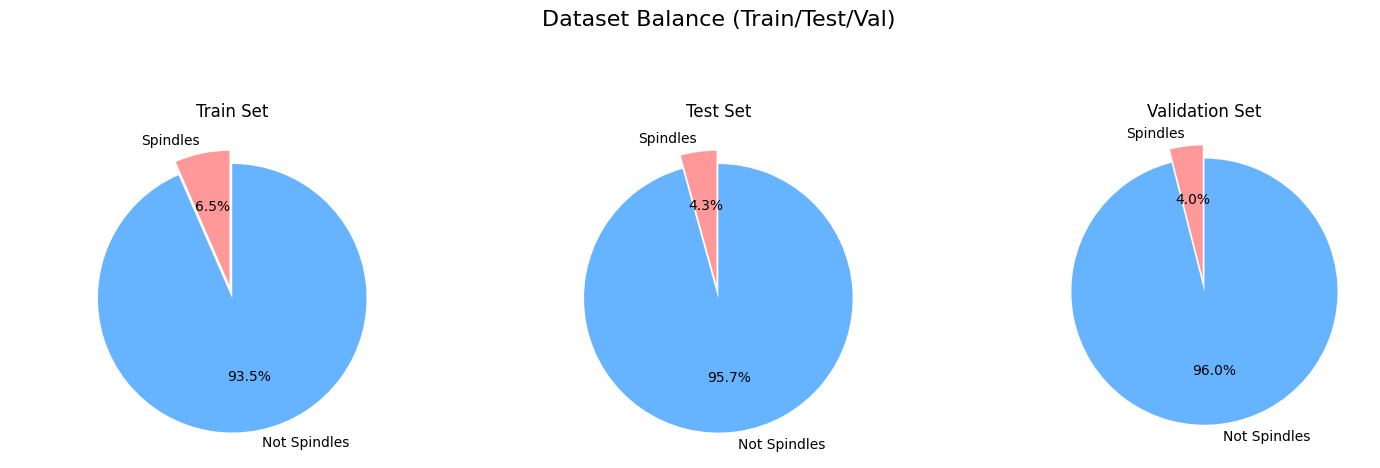

In [ ]:
# Check initial datasets balancing
plot_dataset_balancing(df_train_sw, df_test_sw, df_val_sw)

## Not augmented dataset

Solve the unbalanced situation of the train set:

Here we just cut out non-spindle samples to reach a balancing of 50% spindle and 50% not spindle classes.

Below we also implement an augmentation technique to add synthetic data for the spindles.

In [ ]:
df_train

,is_spindle,patient_id,SpEn,maximum,minimum,variance,std_deviation,PAC,inst_freq,energy_ratio,kurt,skewness,PWRpeak,PWRratio,IQR,zero_crossing
0,0,1,3.091042,-4.868705e-05,-7.753086e-03,3.454844e-06,1.858721e-03,0.004164,-0.001094,8.424509e-08,40.081961,6.329113,1.094418e-06,0.014988,5.618675e-04,31
1,0,1,3.178054,5.689756e-03,-5.422475e-03,7.894295e-06,2.809679e-03,0.012282,0.018894,2.443162e-07,34.898821,5.871523,2.217601e-06,0.013342,1.243414e-03,34
2,0,1,0.597227,7.481033e-02,2.823563e-03,4.841402e-04,2.200319e-02,0.000234,-0.000992,1.662477e-07,42.200411,6.536089,1.593872e-04,0.022406,1.622183e-03,35
3,0,1,1.791759,1.778605e-01,7.482668e-02,8.181524e-04,2.860336e-02,0.000660,-0.000665,8.798987e-08,38.475203,6.183382,2.402906e-04,0.020090,3.979508e-03,35
4,0,1,0.536305,1.818140e-01,-3.264030e-02,2.101107e-03,4.583784e-02,0.003454,-0.001320,1.426887e-07,40.517885,6.372533,5.949377e-04,0.051021,7.360702e-03,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21595,0,6,0.998529,2.094489e+07,-3.569562e+07,2.286229e+14,1.512028e+07,0.003185,0.030598,9.556183e-08,21.404486,4.559362,5.096866e+13,0.003282,1.125520e+07,15
21596,0,6,0.606136,3.287438e+07,-3.014608e+07,3.294393e+14,1.815046e+07,0.006167,0.009239,9.235026e-08,39.486490,6.297664,1.143674e+14,0.005965,4.393623e+06,21
21597,0,6,0.804373,3.510685e+07,-2.581705e+07,2.217440e+14,1.489107e+07,0.006721,0.019018,2.539020e-07,13.573237,3.693109,3.516905e+13,0.030392,1.051285e+07,14
21598,0,6,1.481605,1.815958e+07,-1.941036e+07,6.223977e+13,7.889219e+06,0.024837,0.019746,1.625233e-07,17.154179,4.165170,1.147758e+13,0.026314,3.937557e+06,20


In [ ]:
def manual_undersampling(df_train):
    # Calculate the target number of samples for each class based on the desired balance
    target_sample_count_train = df_train['is_spindle'].sum()

    # Filter spindle and non-spindle samples separately
    spindle_samples_train = df_train[df_train['is_spindle'] == 1]
    non_spindle_samples_train = df_train[df_train['is_spindle'] == 0]

    # Randomly sample from non-spindle samples to achieve the desired balance in the train set
    if len(non_spindle_samples_train) > target_sample_count_train:
        non_spindle_samples_train = non_spindle_samples_train.sample(n=target_sample_count_train, random_state=42)

    # Concatenate the balanced samples for the train and test sets
    df_train_balanced = pd.concat([spindle_samples_train, non_spindle_samples_train])

    # Shuffle the balanced dataframes
    df_train_bal = df_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    return df_train_bal

In [ ]:
# Use manual undersampling technique
df_train_bal = manual_undersampling(df_train)

In [ ]:
# Check number of samples in the training set after balancing
print('Number of samples before balancing the train set:', df_train.shape[0])
print(df_train.head(3))

Number of samples before balancing the train set: 7200
   is_spindle  patient_id      SpEn   maximum   minimum  variance   
0           0           1  3.091042 -0.000049 -0.007753  0.000003  \
1           0           1  3.178054  0.005690 -0.005422  0.000008   
2           0           1  0.597227  0.074810  0.002824  0.000484   

   std_deviation       PAC  inst_freq  energy_ratio       kurt  skewness   
0       0.001859  0.004164  -0.001094  8.424509e-08  40.081961  6.329113  \
1       0.002810  0.012282   0.018894  2.443162e-07  34.898821  5.871523   
2       0.022003  0.000234  -0.000992  1.662477e-07  42.200411  6.536089   

    PWRpeak  PWRratio       IQR  zero_crossing  
0  0.000001  0.014988  0.000562             31  
1  0.000002  0.013342  0.001243             34  
2  0.000159  0.022406  0.001622             35  


In [ ]:
# Check number of samples in the testing set after balancing
print('Number of samples after balancing the train set:', df_train_bal.shape[0])
print(df_train_bal.head(3))

Number of samples after balancing the train set: 934
   is_spindle  patient_id      SpEn       maximum       minimum      variance   
0           1           6  2.302585  2.235818e+07 -2.778601e+07  9.509463e+13  \
1           1           1  0.916291  3.316419e+01 -1.006041e+01  9.781443e+01   
2           1           1  0.729515  5.011269e+01 -1.874925e+01  2.883172e+02   

   std_deviation       PAC  inst_freq  energy_ratio       kurt  skewness   
0   9.751648e+06  0.006722   0.028859  6.633546e-08  11.040097  3.507273  \
1   9.890118e+00  0.008535   0.031238  8.568672e-08  12.824224  3.777990   
2   1.697991e+01  0.003435   0.019341  1.812666e-07  22.421617  4.645477   

        PWRpeak  PWRratio           IQR  zero_crossing  
0  1.338233e+13  0.032957  3.998841e+06             18  
1  1.693386e+01  0.012700  8.107668e+00             14  
2  6.441721e+01  0.005012  1.315404e+01             12  


Now the train dataset is balanced, although we excluded many samples and we don't have that many from our data, so we'll test out also some data augmentation techniques later.

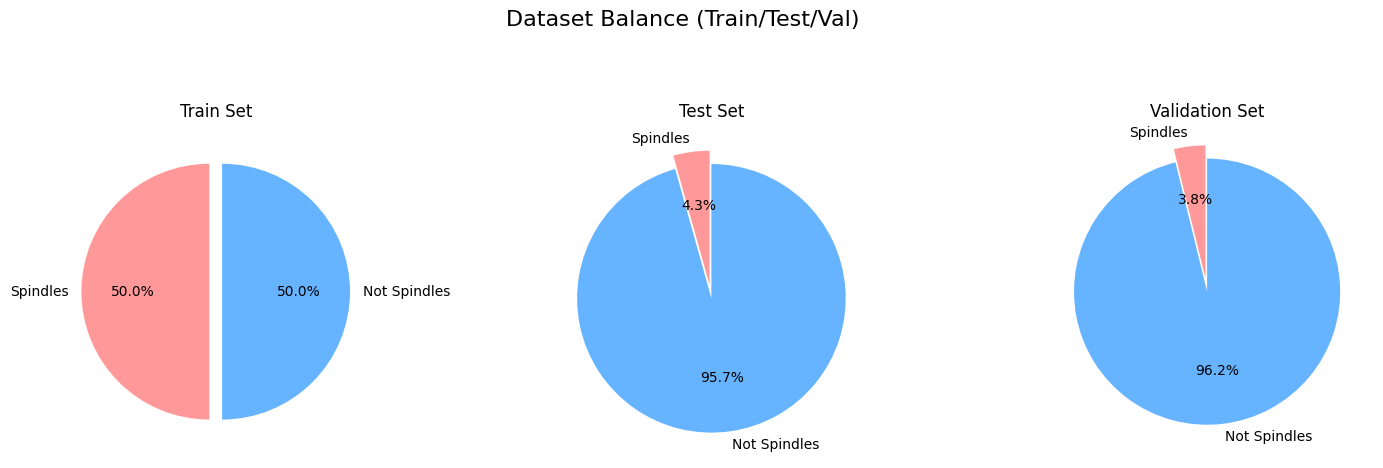

In [ ]:
# Check datasets balancing 
plot_dataset_balancing(df_train_bal, df_test, df_val)

## Augmented Dataset

Here we implement an augmentation technique to add synthetic data for the spindles.

We'll test out different algorithms for the data augmentation: SMOTE, ...

In [ ]:
def oversample_transform(train: pd.DataFrame, target: str, sampling_strategy: float = 'auto'):
    df = train.copy()

    # We split the target and the rest of the features
    y = df[target]
    x = df.drop([target], axis=1)

    # Defining our over-sampler
    over = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

    # Transform the dataset
    x, y = over.fit_resample(x, y)

    # merge the target and the features:
    df = pd.DataFrame(pd.concat([x, y], axis=1))
    return df

#  Accuracy    Precision    Recall    F1 Score    ROC AUC
# ----------  -----------  --------  ----------  ---------
#   0.346852    0.0309667  0.674772   0.0592158    0.50566


def smote_transform(train: pd.DataFrame, target: str, sampling_strategy: float = 'auto'):
    df = train.copy()

    # We split the target and the rest of the features
    y = df[target]
    x = df.drop([target], axis=1)

    # Defining our over-sampler and under-sampler
    over = SMOTE(sampling_strategy=sampling_strategy, random_state=42, n_jobs=-1)

    # Transform the dataset
    x, y = over.fit_resample(x, y)

    # merge the target feature with the rest of the features
    df = pd.DataFrame(pd.concat([x, y], axis=1))
    return df

#   Accuracy    Precision    Recall    F1 Score    ROC AUC
# ----------  -----------  --------  ----------  ---------
#   0.346296    0.0313327  0.683891   0.0599201    0.50979


def adasyn_transform(train: pd.DataFrame, target: str, sampling_strategy: float = 'auto'):
    df = train.copy()

    # We split the target and the rest of the features
    y = df[target]
    x = df.drop([target], axis=1)

    # Defining our over-sampler
    over = ADASYN(sampling_strategy=sampling_strategy, random_state=42, n_jobs=-1)

    # Transform the dataset
    x, y = over.fit_resample(x, y)

    # merge the target feature with the rest of the features
    df = pd.DataFrame(pd.concat([x, y], axis=1))
    return df

#   Accuracy    Precision    Recall    F1 Score    ROC AUC
# ----------  -----------  --------  ----------  ---------
#   0.844444    0.0363761  0.161094   0.0593505   0.513505


def borderline_smote(train: pd.DataFrame, target: str, sampling_strategy: float = 'auto'):
    df = train.copy()

    # We split the target and the rest of the features
    y = df[target]
    X = df.drop([target], axis=1)

    # Defining our over-sampler
    over = BorderlineSMOTE(sampling_strategy=sampling_strategy, random_state=42, n_jobs=-1)

    # Transform the dataset
    x, y = over.fit_resample(X, y)

    # merge the target feature with the rest of the features
    df = pd.DataFrame(pd.concat([x, y], axis=1))
    return df

#   Accuracy    Precision    Recall    F1 Score    ROC AUC
# ----------  -----------  --------  ----------  ---------
#      0.465    0.0300155  0.528875   0.0568071   0.495934


def smote_enn(train: pd.DataFrame, target: str, sampling_strategy: float = 'auto'):
    df = train.copy()

    # We split the target and the rest of the features
    y = df[target]
    x = df.drop([target], axis=1)

    # Defining our over-sampler
    over = SMOTEENN(sampling_strategy=sampling_strategy, random_state=42, n_jobs=-1)

    # Transform the dataset
    x, y = over.fit_resample(x, y)

    # merge the target feature with the rest of the features
    df = pd.DataFrame(pd.concat([x, y], axis=1))
    return df

#   Accuracy    Precision    Recall    F1 Score    ROC AUC
# ----------  -----------  --------  ----------  ---------
#   0.253889     0.031746  0.796353    0.061058   0.516599


def undersample_transform(train: pd.DataFrame, target: str, sampling_strategy: float = 'auto'):
    df = train.copy()

    # We split the target and the rest of the features
    y = df[target]
    x = df.drop([target], axis=1)

    # Defining our under-sampler
    under = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)

    # Transform the dataset
    x, y = under.fit_resample(x, y)

    # merge the target and the features:
    df = pd.DataFrame(pd.concat([x, y], axis=1))
    return df

#   Accuracy    Precision    Recall    F1 Score    ROC AUC
# ----------  -----------  --------  ----------  ---------
#   0.969537            0         0           0        0.5

In [ ]:
# Check dimension of df_train and the number of spindles in it
print('Spindles:', df_train['is_spindle'].value_counts()[1])
print(df_train.shape)

Spindles: 467
(7200, 16)


# Dataset Creation

## Using Dataset without overlaps

In [ ]:
# Use RandomUnderSampler
df_train_randund = undersample_transform(df_train, 'is_spindle')

# Use Manuel Undersampling
df_train_manualund = manual_undersampling(df_train)

In [ ]:
def apply_transformation(transformation_function, df_train, oversampling_ratio='auto'):
    # Use the transformation function given for oversampling the minority class
    df_train_trans = transformation_function(df_train, 'is_spindle', oversampling_ratio)

    # Undersample the majority class to reach 50%  spindles and 50% non-spindles
    df_train_trans = manual_undersampling(df_train_trans)

    return df_train_trans

In [ ]:
# Get the oversampling transformation of df_train for each method
df_train_adasyn = apply_transformation(adasyn_transform, df_train, 0.14)  # Apply ADASYN
df_train_smote = apply_transformation(smote_transform, df_train, 0.14)  # Apply SMOTE
df_train_smoteenn = apply_transformation(smote_enn, df_train, 0.14)  # Apply SMOTE ENN
df_train_border = apply_transformation(borderline_smote, df_train, 0.14) # Apply Borderline SMOTE
df_train_randover = apply_transformation(oversample_transform, df_train, 0.14)  # Apply RandomOverSampler

Dataset balance using ADASYN


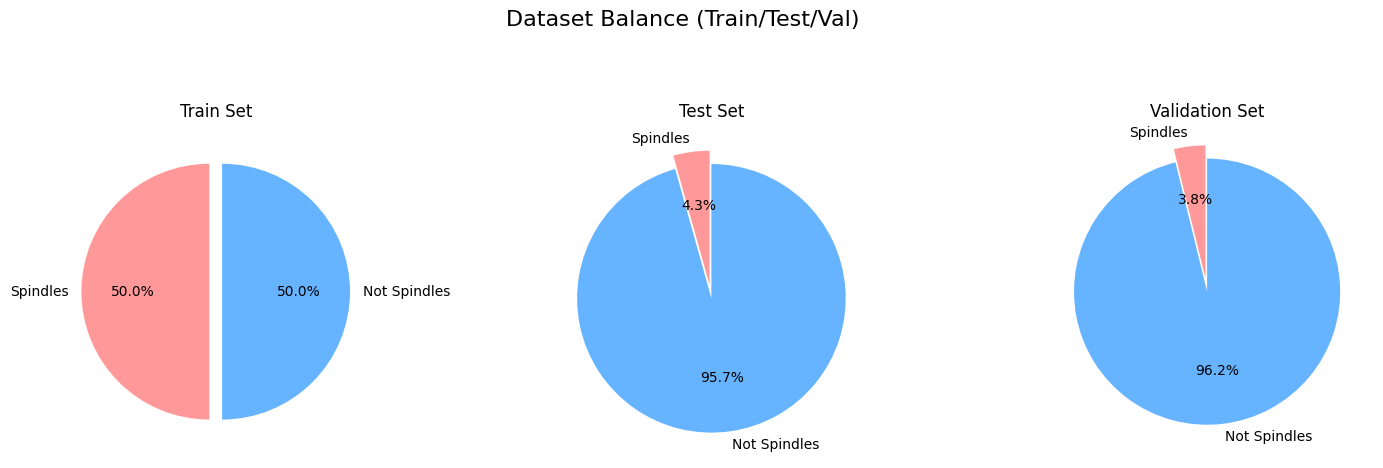

Dataset balance using SMOTE


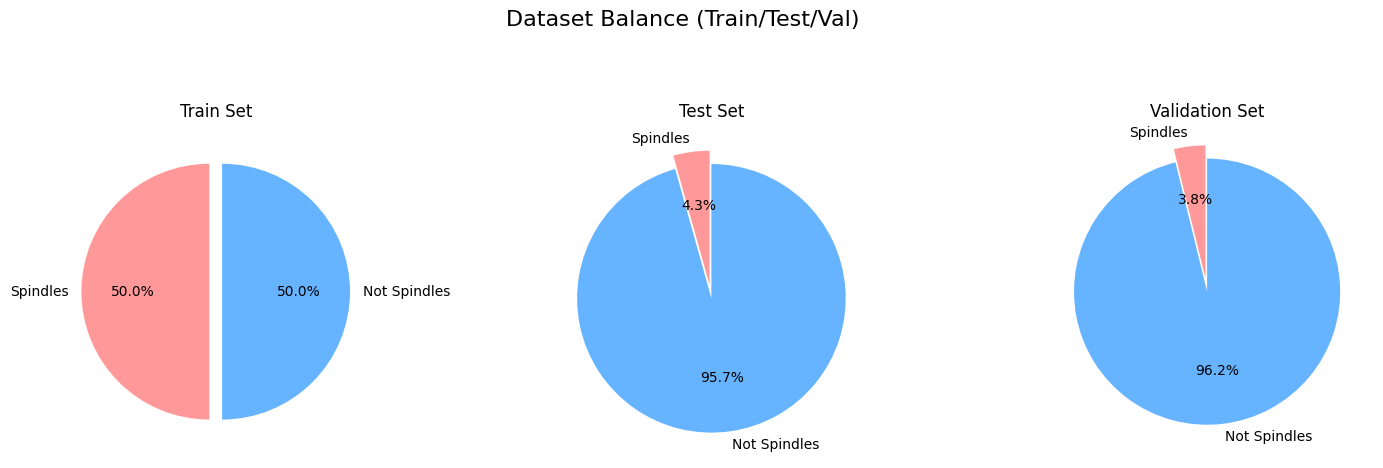

Dataset balance using SMOTE ENN


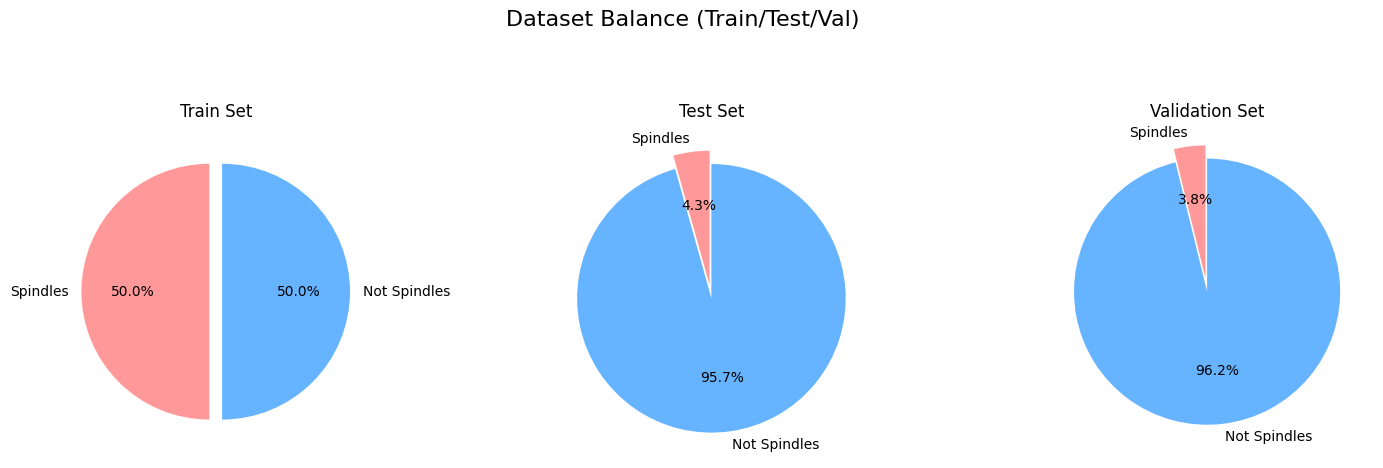

Dataset balance using Borderline SMOTE


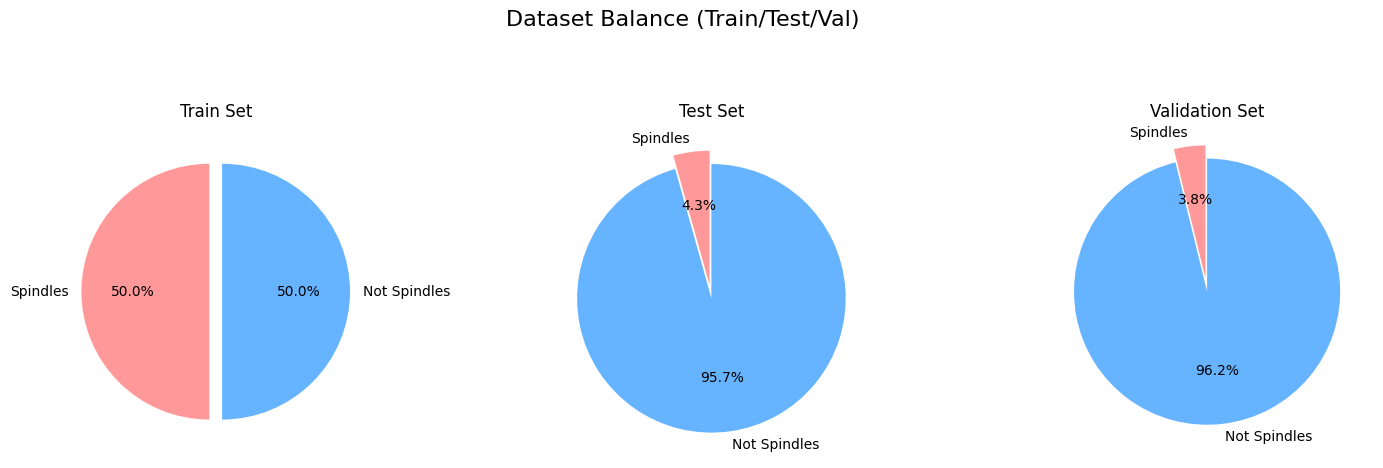

Dataset balance using RandomOverSampler


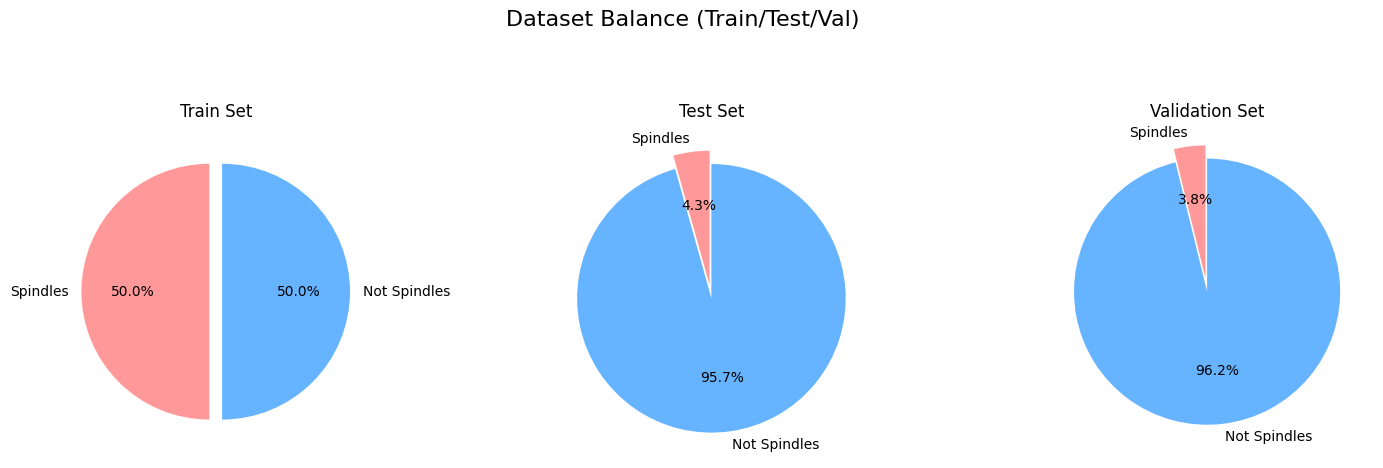

Dataset balance using Manual Undersampling


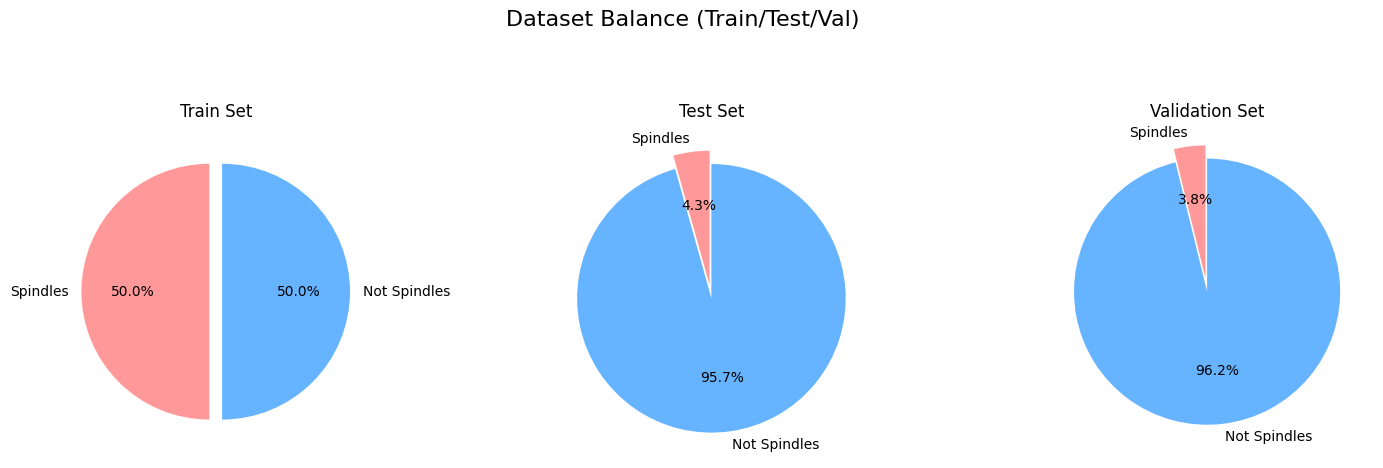

In [ ]:
# Check datasets balancing after augmentation for each method
dfs_train = {'ADASYN': df_train_adasyn, 'SMOTE': df_train_smote, 'SMOTE ENN': df_train_smoteenn, 'Borderline SMOTE': df_train_border, 'RandomOverSampler': df_train_randover, 'Manual Undersampling': df_train_manualund}
for df_train_name, df_train in dfs_train.items():
    print('Dataset balance using', df_train_name)
    plot_dataset_balancing(df_train, df_test, df_val)

## Using Dataset with overlapping windows

In [ ]:
# Use RandomUnderSampler
df_train_randund_sw = undersample_transform(df_train_sw, 'is_spindle')

# Use RandomUnderSampler
df_train_manualund_sw = manual_undersampling(df_train_sw)

In [ ]:
# Get the oversampling transformation of df_train for each method
df_train_adasyn_sw = apply_transformation(adasyn_transform, df_train_sw, 0.14)  # Apply ADASYN
df_train_smote_sw = apply_transformation(smote_transform, df_train_sw, 0.14)  # Apply SMOTE
df_train_smoteenn_sw = apply_transformation(smote_enn, df_train_sw, 0.14)  # Apply SMOTE ENN
df_train_border_sw = apply_transformation(borderline_smote, df_train_sw, 0.14) # Apply Borderline SMOTE
df_train_randover_sw = apply_transformation(oversample_transform, df_train_sw, 0.14)  # Apply RandomOverSampler

Dataset balance using ADASYN


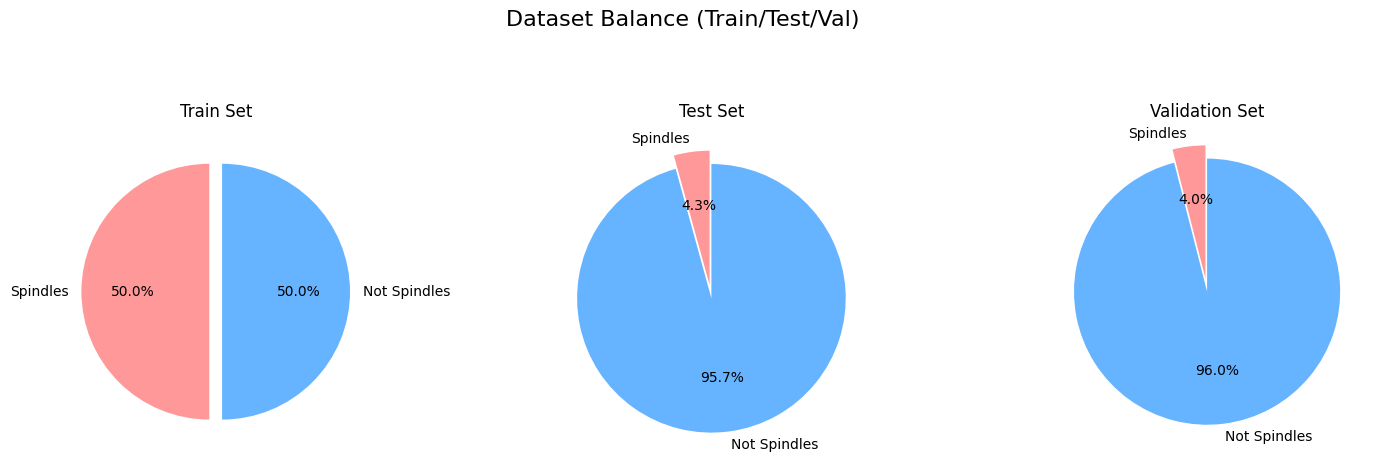

Dataset balance using SMOTE


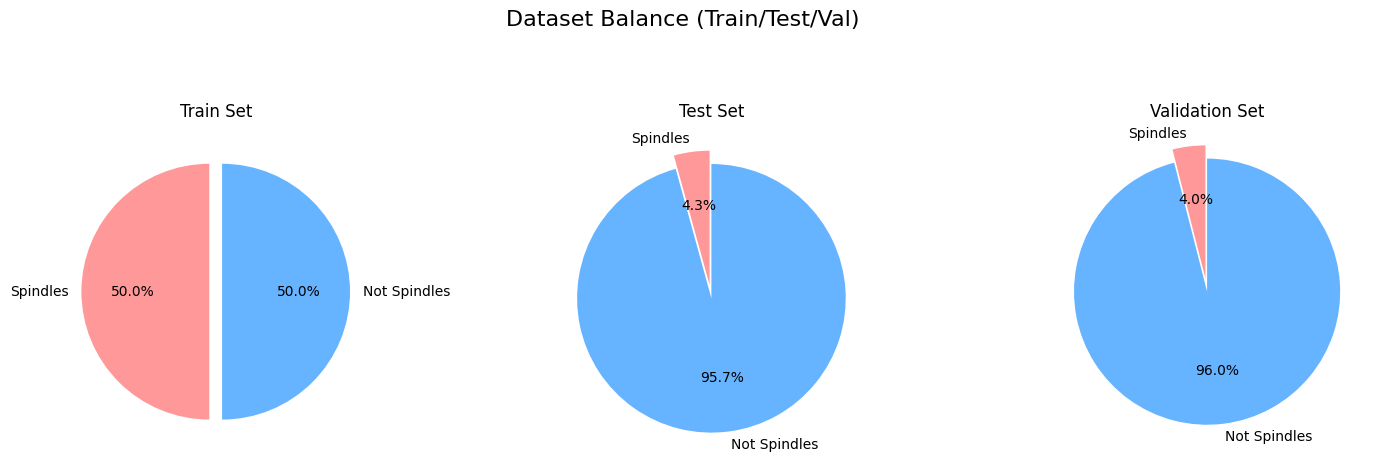

Dataset balance using SMOTE ENN


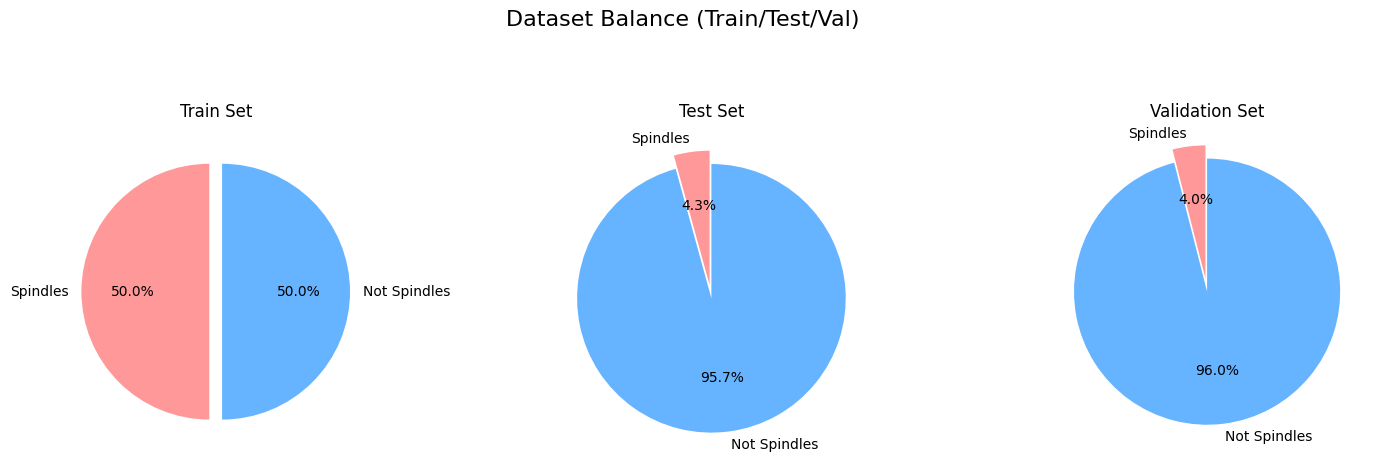

Dataset balance using Borderline SMOTE


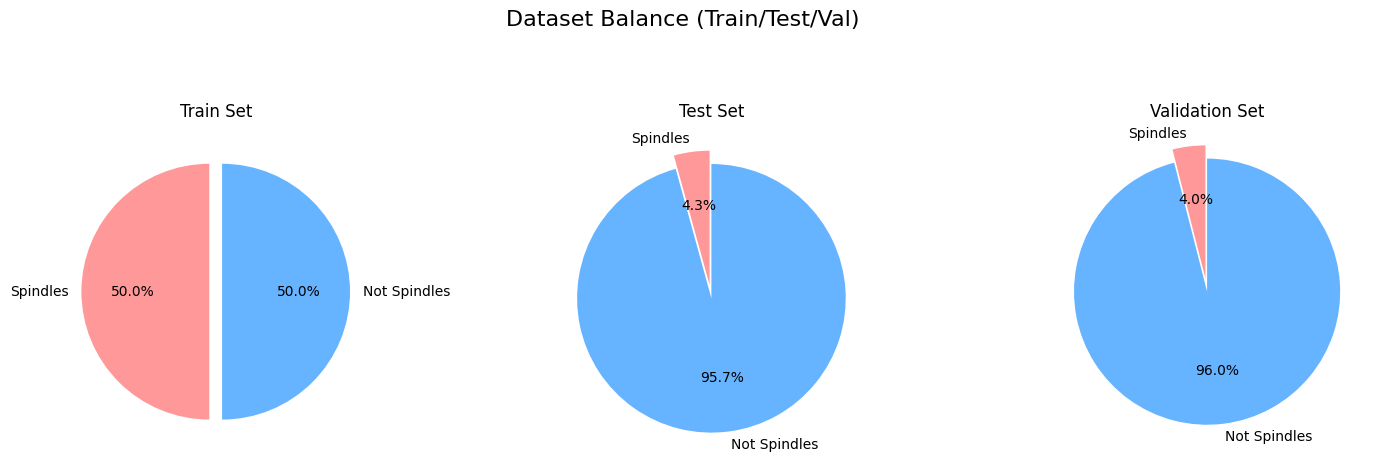

Dataset balance using RandomOverSampler


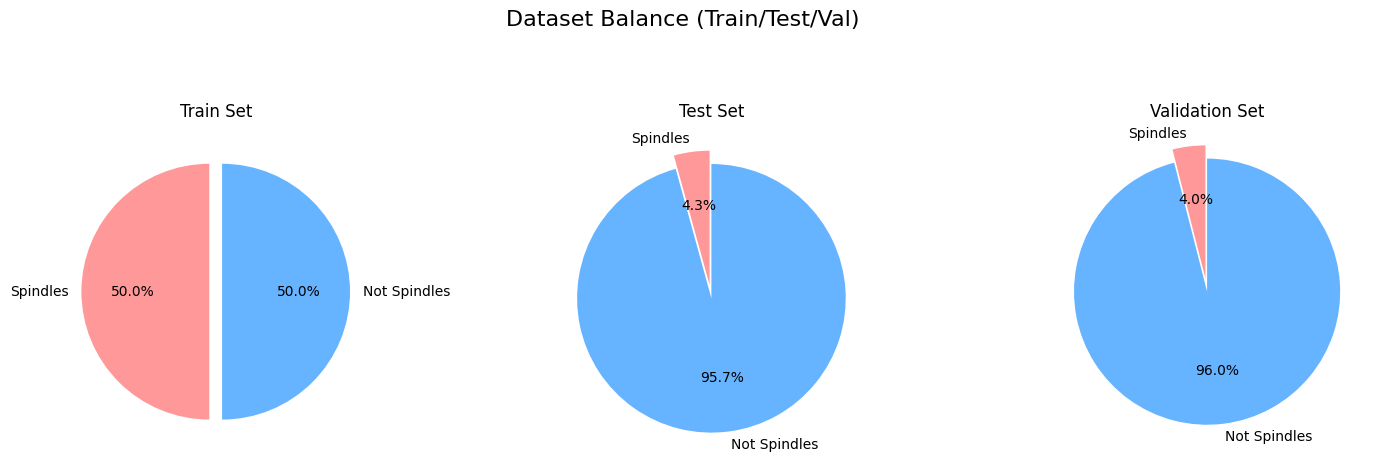

Dataset balance using Manual Undersampling


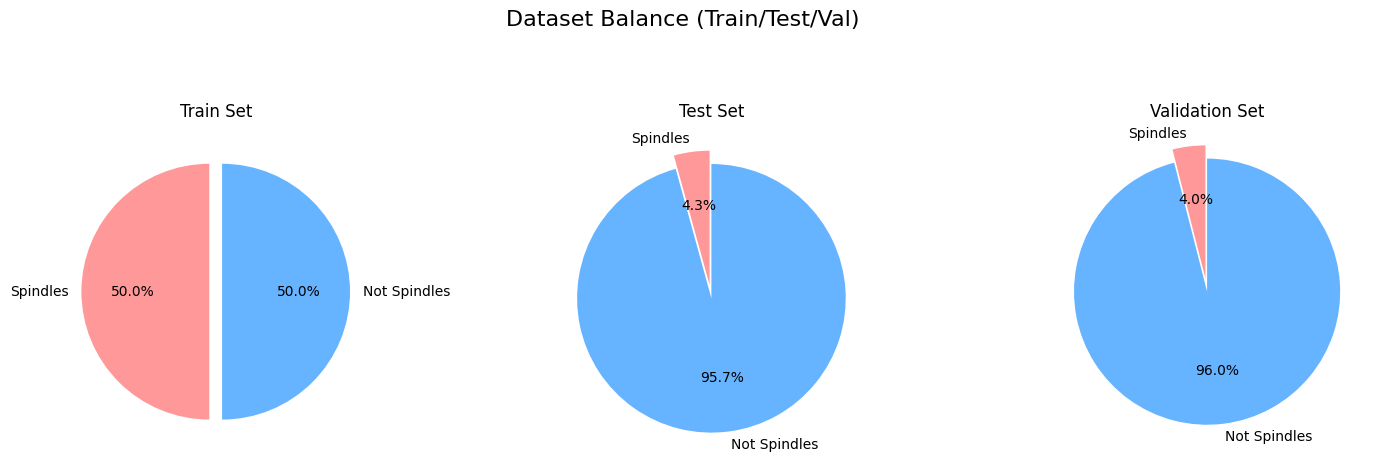

In [ ]:
# Check datasets balancing after augmentation for each method
dfs_train_sw = {'ADASYN': df_train_adasyn_sw, 'SMOTE': df_train_smote_sw, 'SMOTE ENN': df_train_smoteenn_sw, 'Borderline SMOTE': df_train_border_sw, 'RandomOverSampler': df_train_randover_sw, 'Manual Undersampling': df_train_manualund_sw}
for df_train_name, df_train in dfs_train_sw.items():
    print('Dataset balance using', df_train_name)
    plot_dataset_balancing(df_train, df_test_sw, df_val_sw)

# Modelling

## Using Dataset without overlaps

In [ ]:
# Function to evaluate the model
def evaluate_model(y_true, y_pred):    
    # Convert continuous targets to binary targets using a threshold of 0.5
    y_true_binary = y_true #(y_true > 0.5).astype(int)
    y_pred_binary = y_pred # (y_pred > 0.5).astype(int)

    # Calculate evaluation metrics on binary targets
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    roc_auc = roc_auc_score(y_true, y_pred)
    sensitivity = recall_score(y_true_binary, y_pred_binary, pos_label=1)  
    specificity = recall_score(y_true_binary, y_pred_binary, pos_label=0)
    FPR = 1 - specificity
    conf_mat = confusion_matrix(y_true_binary, y_pred_binary)
    conf_mat

    # Create a list of metric names and values
    metrics = ["Sensitivity", "Specificity", "FPR", "F1 Score", "ROC AUC", "Precision", "Accuracy"]
    values = [sensitivity, specificity, FPR, f1, roc_auc, precision, accuracy]

    # Create a list of lists for tabulating
    table = [metrics, values]

    # Display the table
    print(tabulate(table, headers='firstrow'))


    # Create a heatmap of the confusion matrix
    sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])

    # Add labels and title
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

    return [sensitivity, specificity, FPR, f1, roc_auc, precision, accuracy]

In [ ]:
# Define variable containing the target feature name
target = 'is_spindle'

Dataset balance using ADASYN
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
     0.271565       0.871933  0.128067    0.132812   0.571749    0.0879007    0.845833


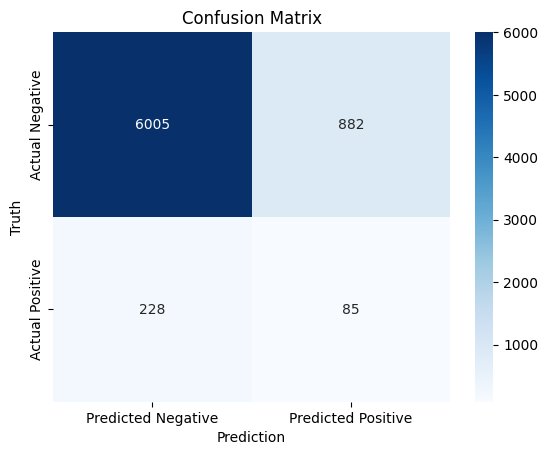

Dataset balance using SMOTE
  Sensitivity    Specificity        FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  ---------  ----------  ---------  -----------  ----------
     0.242812       0.901699  0.0983011    0.142589   0.572255      0.10093    0.873056


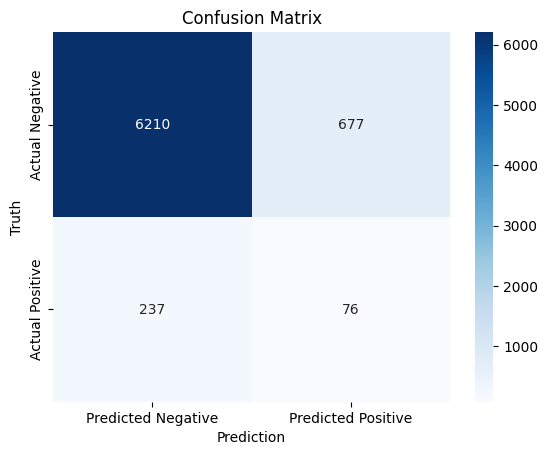

Dataset balance using SMOTE ENN
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
     0.440895       0.394221  0.605779   0.0597015   0.417558    0.0320186     0.39625


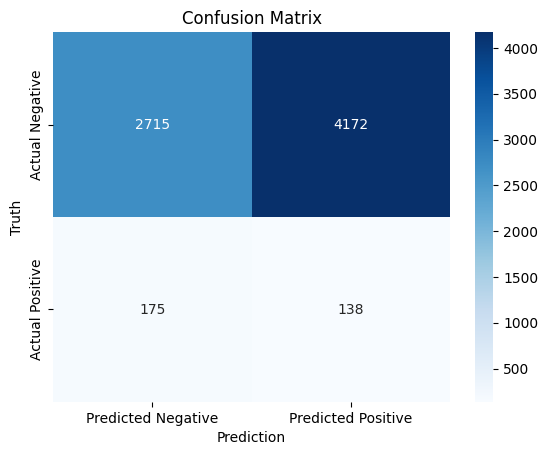

Dataset balance using Borderline SMOTE
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
     0.271565       0.865253  0.134747    0.128205   0.568409    0.0839092    0.839444


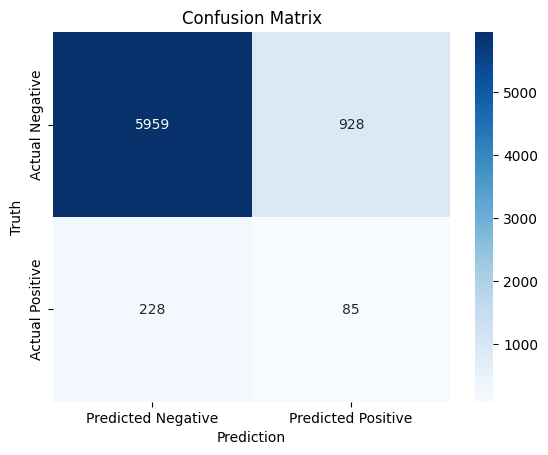

Dataset balance using RandomOverSampler
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
      0.27476       0.861769  0.138231    0.127313   0.568264    0.0828516     0.83625


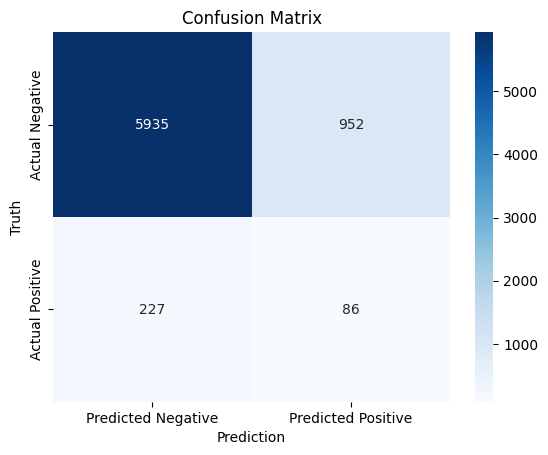

Dataset balance using Manual Undersampling
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
     0.277955       0.849862  0.150138    0.121339   0.563909    0.0776093       0.825


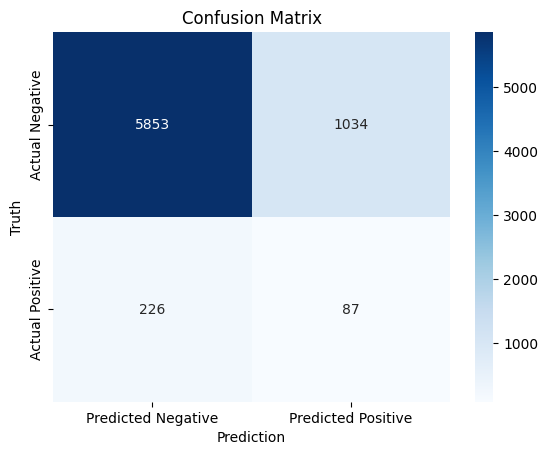

In [ ]:
# Check datasets balancing after augmentation for each method
x_test = df_test.drop(target, axis=1)
y_test = df_test[target]

for df_train_name, df_train in dfs_train.items():
    print('Dataset balance using', df_train_name)

    x_train = df_train.drop(target, axis=1)
    y_train = df_train[target]

    model = SVC(random_state=42)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    evaluate_model(y_test, pred)

### Tuning

In [ ]:
# # Use the best augmeted data to run hyper-parameters tuning
# train = dfs_train['Borderline SMOTE']  # Borderline SMOTE seems to be the best method

# x_train = train.drop(target, axis=1)
# y_train = train[target]

# x_test = df_test.drop(target, axis=1)
# y_test = df_test[target]

# x_val = df_val.drop(target, axis=1)
# y_val = df_val[target]

#### XGBoost Classifier

In [ ]:
# def objective(space, x_train: pd.DataFrame, y_train: pd.DataFrame, x_val: pd.DataFrame, y_val: pd.DataFrame,
#               cross_validation: int = 5, fast: bool = False):
    
#     model = XGBClassifier(n_estimators=space['n_estimators'],
#                           max_depth=space['max_depth'],
#                           learning_rate=space['learning_rate'],
#                           min_child_weight=space['min_child_weight'],
#                           gamma=space['gamma'],
#                           subsample=space['subsample'],
#                           colsample_bytree=space['colsample_bytree'],
#                           reg_alpha=space['reg_alpha'],
#                           reg_lambda=space['reg_lambda'],
#                           objective="binary:logistic",
#                           eval_metric="logloss",
#                           random_state=42,
#                           n_jobs=-1)

#     # define the model evaluation data
#     X = pd.concat([x_train, x_val])
#     y = pd.concat([y_train, y_val])

#     cv = StratifiedKFold(n_splits=cross_validation, shuffle=True, random_state=42)

#     if fast:
#         cv = 2

#     metric = make_scorer(roc_auc_score)

#     # evaluate the model:
#     mm = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1).mean()

#     return {'loss': 1-mm, 'status': STATUS_OK}


# def tuner(x_train: pd.DataFrame, y_train: pd.DataFrame,
#           x_val: pd.DataFrame, y_val: pd.DataFrame, max_evaluations: int = 100,
#           cross_validation: int = 5, fast: bool = False) -> dict:

#     # define the search space, choose the parameters to tune:
#     space = {
#         'n_estimators': hp.choice('n_estimators', range(100, 1000)),
#         'max_depth': hp.choice('max_depth', range(1, 20)),
#         'learning_rate': hp.uniform('learning_rate', 0.01, 1),
#         'min_child_weight': hp.choice('min_child_weight', range(1, 10)),
#         'gamma': hp.uniform('gamma', 0.01, 1),
#         'subsample': hp.uniform('subsample', 0.01, 1),
#         'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1),
#         'reg_alpha': hp.uniform('reg_alpha', 0.01, 1),
#         'reg_lambda': hp.uniform('reg_lambda', 0.01, 1)
#     }

#     # define the trials object:
#     trials = Trials()

#     # run the optimization:
#     best = fmin(fn=lambda search_space: objective(search_space, x_train, y_train, x_val, y_val,
#                                                   cross_validation, fast),
#                 space=space, algo=tpe.suggest, max_evals=max_evaluations, trials=trials)

#     # filter out the parameters that are 0:
#     best = {k: v for k, v in best.items() if v != 0}

#     return best

# # # tune the model:
# # best = tuner(x_train, y_train, x_val, y_val, max_evaluations=100, cross_validation=5, fast=False)

# # # print the best parameters:
# # print(best)

# # # train the model with the best parameters:
# # model = XGBClassifier(**best, objective="binary:logistic", eval_metric="logloss", random_state=42, n_jobs=-1)

# # # fit the model:
# # model.fit(x_train, y_train)

# # # evaluate the model on the test set
# # pred = model.predict(x_test)
# # _ = evaluate_model(y_test, pred)

#### Support Vector Machine Classifier

In [ ]:
# # The hyper-opt library for hyper-parameter tuning seems to not work on SVC, so we'll use GridSearchCV instead
# # defining parameter range
# param_grid = {'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
#               'degree': [1, 2, 3, 4]}
  
# # scorers = {'roc_auc': 'roc_auc', 'recall': make_scorer(recall_score, pos_label=1)}


# grid = GridSearchCV(SVC(), param_grid, refit = 'roc_auc', verbose = 3, scoring='roc_auc')
  
# # fitting the model for grid search
# grid.fit(x_val, y_val)

# # print best parameter after tuning
# print(grid.best_params_)
  
# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)

# # Print the ROC-AUC score on the validation set using the best model
# y_val_pred = grid.best_estimator_.predict(x_val)

# roc_auc = roc_auc_score(y_val, y_val_pred)
# print("ROC-AUC score on validation set:", roc_auc)

In [ ]:
# grid_predictions = grid.predict(x_test)
  
# # print classification report
# print(classification_report(y_test, grid_predictions))

In [ ]:
# # Evaluate the model on the test set
# svc = grid.best_estimator_
# pred = svc.predict(x_test)
# _ = evaluate_model(y_test, pred)

In [ ]:
# Code to run hyperopt on SVC, but it doesn't work as intended
# def objective(space, x_train: pd.DataFrame, y_train: pd.DataFrame, x_test: pd.DataFrame, y_test: pd.DataFrame,
#               cross_validation: int = 5, fast: bool = False):

#     model = SVC(C=space['C'],
#                 kernel=space['kernel'],
#                 # degree=space['degree'],
#                 random_state=42)

#     # define the model evaluation data
#     X = pd.concat([x_train, x_test])
#     y = pd.concat([y_train, y_test])

#     # since we have an imbalanced dataset, we need to use stratified k-fold cross-validation:
#     cv = StratifiedKFold(n_splits=cross_validation, shuffle=True, random_state=42)

#     if fast:
#         cv = 2

#     metric = make_scorer(roc_auc_score)

#     # evaluate the model:
#     roc_auc = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1).mean()

#     return {'loss': 1 - roc_auc, 'status': STATUS_OK}


# def tuner(x_train: pd.DataFrame, y_train: pd.DataFrame,
#           x_test: pd.DataFrame, y_test: pd.DataFrame, max_evaluations: int = 100,
#           cross_validation: int = 5, fast: bool = False):

#     # define the search space, choose the parameters to tune:
#     space = {
#         'C': hp.uniform('C', 0.1, 1),
#         'kernel': hp.choice('kernel', ['linear', 'rbf', 'sigmoid', 'poly']),
#         'degree': hp.choice('degree', [2, 3, 4, 5, 6]),
#         'degree': hp.choice('degree', [2, 3, 4]),

#     }

#     # define the trials object:
#     trials = Trials()

#     # run the optimization:
#     best = fmin(fn=lambda search_space: objective(search_space, x_train, y_train, x_test, y_test,
#                                                   cross_validation, fast),
#                 space=space, algo=tpe.suggest, max_evals=max_evaluations, trials=trials)

#     # filter out the parameters that are 0:
#     best = {k: v for k, v in best.items() if v != 0}

#     return best

# # tune the model:
# best = tuner(x_train, y_train, x_test, y_test, max_evaluations=10, cross_validation=5, fast=True)
# print(best)

# # train the model with the best parameters:
# model = SVC(**best, random_state=42)
# model.fit(x_train, y_train)

# # train the model:
# model.fit(x_train, y_train)

# # evaluate the model:
# pred = model.predict(x_test)
# _ = evaluate_model(y_test, pred)

## Using Dataset with overlapping windows

In [ ]:
def post_processing(pred):
    processed_pred = []
    for i in range(1, len(pred)-1):
        if pred[i] == 0 and pred[i-1] == 1 and pred[i+1] == 1:
            pred[i] = 1
    for i in range(int(len(pred)/5)):
        # print(pred[i*5:i*5+5])
        if sum(pred[i*5:i*5+5]) < 2:
            processed_pred.append(0)
        else:
            processed_pred.append(1)
    return processed_pred
    
pred = [0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,1,1,1,0,0,1,1]
post_processing(pred)

[0, 1, 0, 1, 0, 1]

Dataset balance using ADASYN
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
     0.315175       0.831988  0.168012     0.12436   0.573582    0.0774625    0.809847


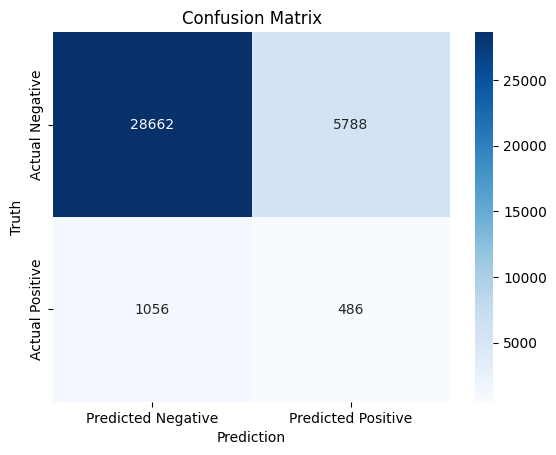

Dataset balance using SMOTE
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
     0.306744       0.838345  0.161655    0.124736   0.572545    0.0782853     0.81557


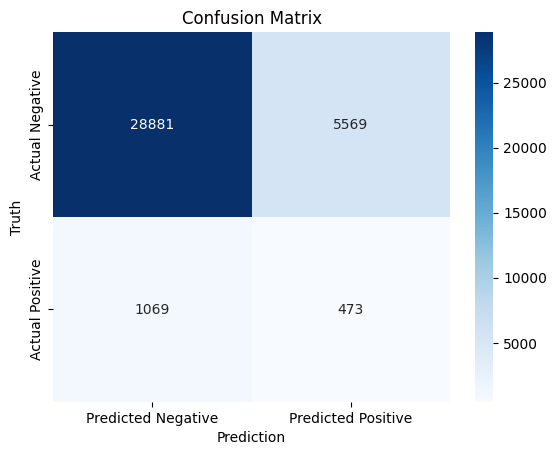

Dataset balance using SMOTE ENN
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
     0.472114       0.401219  0.598781   0.0635863   0.436667    0.0340888    0.404257


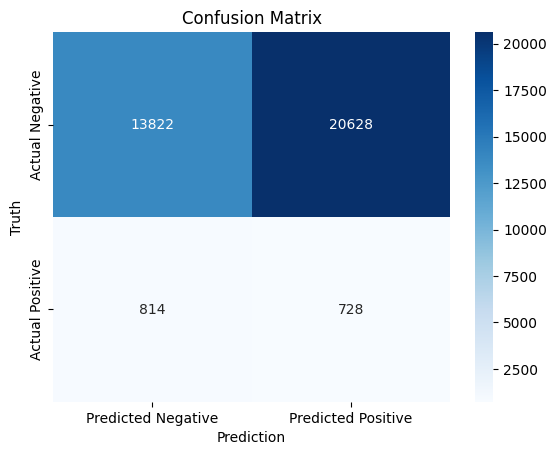

Dataset balance using Borderline SMOTE
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
     0.271077       0.866967  0.133033     0.12777   0.569022    0.0835833    0.841437


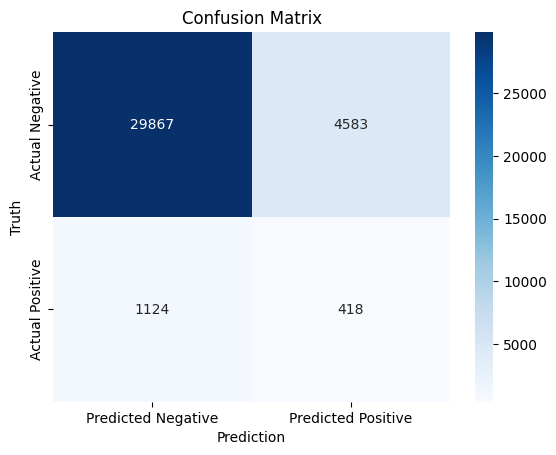

Dataset balance using RandomOverSampler
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
     0.309987       0.833701  0.166299    0.123371   0.571844    0.0770098    0.811264


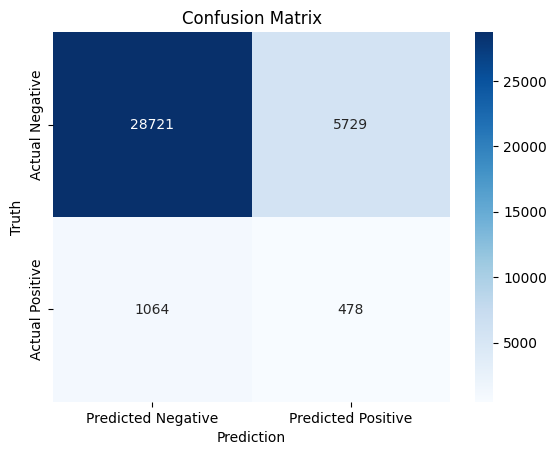

Dataset balance using Manual Undersampling
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
     0.305447       0.833788  0.166212    0.121721   0.569618    0.0760045    0.811152


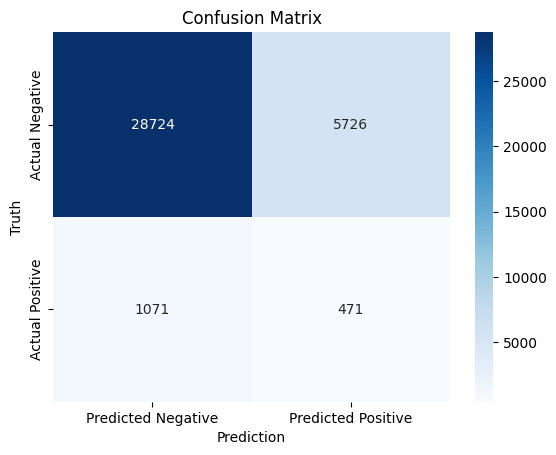

In [ ]:
# # Check datasets balancing after augmentation for each method
# x_test_sw = df_test_sw.drop(target, axis=1)
# y_test_sw = df_test_sw[target]

# for df_train_name_sw, df_train_sw in dfs_train_sw.items():
#     print('Dataset balance using', df_train_name_sw)

#     x_train_sw = df_train_sw.drop(target, axis=1)
#     y_train_sw = df_train_sw[target]

#     model = SVC(random_state=42)
#     model.fit(x_train_sw, y_train_sw)

#     pred_sw = model.predict(x_test_sw)
#     pred_sw = pred_sw

#     y_test_sw = y_test_sw
#     evaluate_model(y_test_sw, pred_sw)

### Tuning

In [ ]:
# Use the best augmeted data to run hyper-parameters tuning
train_sw = dfs_train_sw['Borderline SMOTE']  # Borderline SMOTE seems to be the best method

x_train_sw = train_sw.drop(target, axis=1)
y_train_sw = train_sw[target]

x_test_sw = df_test_sw.drop(target, axis=1)
y_test_sw = df_test_sw[target]

x_val_sw = df_val_sw.drop(target, axis=1)
y_val_sw = df_val_sw[target]

#### XGBoost Classifier

In [ ]:
# def objective(space, x_train: pd.DataFrame, y_train: pd.DataFrame, x_val: pd.DataFrame, y_val: pd.DataFrame,
#               cross_validation: int = 5, fast: bool = False):
    
#     model = XGBClassifier(n_estimators=space['n_estimators'],
#                           max_depth=space['max_depth'],
#                           learning_rate=space['learning_rate'],
#                           min_child_weight=space['min_child_weight'],
#                           gamma=space['gamma'],
#                           subsample=space['subsample'],
#                           colsample_bytree=space['colsample_bytree'],
#                           reg_alpha=space['reg_alpha'],
#                           reg_lambda=space['reg_lambda'],
#                           objective="binary:logistic",
#                           eval_metric="logloss",
#                           random_state=42,
#                           n_jobs=-1)

#     # define the model evaluation data
#     X = pd.concat([x_train, x_val])
#     y = pd.concat([y_train, y_val])

#     cv = StratifiedKFold(n_splits=cross_validation, shuffle=True, random_state=42)

#     if fast:
#         cv = 2

#     metric = make_scorer(roc_auc_score)

#     # evaluate the model:
#     mm = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1).mean()

#     return {'loss': 1-mm, 'status': STATUS_OK}


# def tuner(x_train: pd.DataFrame, y_train: pd.DataFrame,
#           x_val: pd.DataFrame, y_val: pd.DataFrame, max_evaluations: int = 100,
#           cross_validation: int = 5, fast: bool = False) -> dict:

#     # define the search space, choose the parameters to tune:
#     space = {
#         'n_estimators': hp.choice('n_estimators', range(100, 1000)),
#         'max_depth': hp.choice('max_depth', range(1, 20)),
#         'learning_rate': hp.uniform('learning_rate', 0.01, 1),
#         'min_child_weight': hp.choice('min_child_weight', range(1, 10)),
#         'gamma': hp.uniform('gamma', 0.01, 1),
#         'subsample': hp.uniform('subsample', 0.01, 1),
#         'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1),
#         'reg_alpha': hp.uniform('reg_alpha', 0.01, 1),
#         'reg_lambda': hp.uniform('reg_lambda', 0.01, 1)
#     }

#     # define the trials object:
#     trials = Trials()

#     # run the optimization:
#     best = fmin(fn=lambda search_space: objective(search_space, x_train, y_train, x_val, y_val,
#                                                   cross_validation, fast),
#                 space=space, algo=tpe.suggest, max_evals=max_evaluations, trials=trials)

#     # filter out the parameters that are 0:
#     best = {k: v for k, v in best.items() if v != 0}

#     return best

# # tune the model:
# best_sw = tuner(x_train_sw, y_train_sw, x_val_sw, y_val_sw, max_evaluations=100, cross_validation=5, fast=False)

# # print the best parameters:
# print(best_sw)

# # train the model with the best parameters:
# model = XGBClassifier(**best_sw, objective="binary:logistic", eval_metric="logloss", random_state=42, n_jobs=-1)

# # fit the model:
# model.fit(x_train_sw, y_train_sw)

# # evaluate the model on the test set
# pred = model.predict(x_test_sw)
# pred = post_processing(pred)
# #y_test_sw = post_processing(y_test_sw.to_list())
# _ = evaluate_model(y_test_sw, pred)


# """
# Sensitivity    Specificity        FPR    F1 Score    ROC AUC    Precision    Accuracy
# -------------  -------------  ---------  ----------  ---------  -----------  ----------
#      0.216895        0.97929  0.0207101    0.282318   0.598092     0.404255    0.932898
# """

  2%|▏         | 2/100 [01:10<59:01, 36.14s/trial, best loss: 0.2163582951510883]

#### Support Vector Machine Classifier

In [ ]:
# defining parameter distributions for RandomizedSearchCV
param_dist = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
              'degree': [1, 2, 3, 4]}

# Define the scoring metrics for RandomizedSearchCV
# scorers = {'roc_auc': 'roc_auc', 'recall': make_scorer(recall_score, pos_label=1)}

# Create an instance of RandomizedSearchCV
random_search = RandomizedSearchCV(SVC(), param_distributions=param_dist, refit='roc_auc', verbose=3, scoring='roc_auc', n_iter=10)

# Fit the model for random search
random_search.fit(x_train_sw, y_train_sw)

# Print the best parameters after tuning
print(random_search.best_params_)

# Print how our model looks after hyperparameter tuning
print(random_search.best_estimator_)

# Print the ROC-AUC score on the validation set using the best model
y_val_pred_sw = random_search.best_estimator_.predict(x_val_sw)

y_val_pred_sw = post_processing(y_val_pred_sw.to_list())
y_val_sw = post_processing(y_val_sw.to_list())
roc_auc = roc_auc_score(y_val_sw, y_val_pred_sw)
print("ROC-AUC score on validation set:", roc_auc)

In [ ]:
y_test_pred_sw = random_search.predict(x_test_sw)

# print classification report
y_test_pred_sw = post_processing(y_test_pred_sw.to_list())
#y_test_sw = post_processing(y_test_sw.to_list())
print(classification_report(y_test_sw, y_test_pred_sw))

In [ ]:
# Evaluate the model on the test set
svc_sw = random_search.best_estimator_
pred_sw = svc_sw.predict(x_test_sw)
pred_sw = post_processing(pred_sw.to_list())
_ = evaluate_model(y_test_sw, pred_sw)

# Replicate paper implementation

In [ ]:
def patient_train_test(patient, mask_1, mask_2, pn, ratio=0.2, has_overlaps=False):
    n_spindles = 0
    state = 0
    final_index = 0
    indexes = []

    freq = 20 if has_overlaps else 100
    num_samples_per_patient = 17996 if has_overlaps else 3600

    n = int(patient['is_spindle'].sum()*ratio/3)
    # print(patient['is_spindle'].sum())
    print(n)
    for i in range(len(mask_1)):
        if mask_1[i] == 1 or mask_2[i] == 1:
            if state == 0:
                state = 1
        else:
            if state == 1:
                state = 0
                n_spindles += 1
        if n_spindles >= n:
            final_index = i
            break
    # print(final_index)

    
    spindles = patient[(patient['is_spindle'] == 1) & (patient.index <= int(final_index/freq)+1+pn*num_samples_per_patient)]
    non_spindles = patient[(patient['is_spindle'] == 0) & (patient.index <= int(final_index/freq)+1+pn*num_samples_per_patient)]
    indexes += (spindles.index.to_list())
    random.seed(42)
    for i in range(len(spindles)):
        indexes.append(non_spindles.iloc[random.randint(0, len(non_spindles)-1)].name)

    return patient.loc[patient.index.isin(indexes)], patient[patient.index >= int(final_index/100)+1+pn*num_samples_per_patient]

## Using dataset with overlapping windows

In [ ]:
# Split the data into train and test sets using patient based fashion
patient_based_train_sw = []
patient_based_test_sw = []

for i in range(NUM_PATIENTS):
    patient_train, patient_test = patient_train_test(df_sw[df_sw['patient_id']==i+1], masks_1[i], masks_2[i], i, has_overlaps=True)
    patient_based_train_sw.append(patient_train)
    patient_based_test_sw.append(patient_test)

81
51
36
43
66
75


In [ ]:
# Check the patient based training set
patient_based_train_sw

[       is_spindle  patient_id      SpEn    maximum    minimum    variance   
 6               0           1  3.258097   0.012653  -0.001607    0.000011  \
 9               0           1  0.925769   0.055720   0.001052    0.000224   
 27              0           1  1.466337   7.606043  -8.839183   13.455803   
 35              0           1  2.564949  15.391511 -15.691430   50.703086   
 53              0           1  3.258097   8.247363  -7.285555   15.733722   
 ...           ...         ...       ...        ...        ...         ...   
 11504           1           1  0.753772  40.674527 -13.492249  205.917804   
 11505           1           1  0.798508  40.674527 -22.864116  328.980465   
 11506           1           1  0.480366  40.674527 -31.898885  377.494565   
 11507           1           1  0.729961  19.097962 -31.898885  167.079021   
 11508           0           1  0.644829  32.706810 -31.898885  210.408169   
 
        std_deviation       PAC  inst_freq  energy_ratio      

In [ ]:
def get_models_and_scores(patient_based_train, patient_based_test, has_overlaps=False):
    # Patient based data 
    patient_based_models = []
    patient_based_scores = []
    for patient_num in range(NUM_PATIENTS):
        # Split data
        x_train = patient_based_train[patient_num].drop(target, axis=1)
        y_train = patient_based_train[patient_num][target]

        # Test on the single patient
        x_test = patient_based_test[patient_num].drop(target, axis=1)
        y_test = patient_based_test[patient_num][target]

        # Test on the whole dataset
        # x_test = [patient.drop(target, axis=1) for patient in patient_based_test]
        # x_test = pd.concat(x_test, axis=0)
        # y_test = pd.concat([df[target] for df in patient_based_test], ignore_index=True)

        # Train the model
        model = SVC(random_state=42)
        model.fit(x_train, y_train)
        
        # Make predictions and evaluate model
        pred = model.predict(x_test)

        if has_overlaps:
            pred = post_processing(pred)
            y_test = post_processing(y_test.to_list())

        print(f"Patient based model: {patient_num}")
        scores = evaluate_model(y_test, pred)

        patient_based_models.append(model)
        patient_based_scores.append(scores)
        
    return patient_based_models, patient_based_scores

Patient based model: 0
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
     0.794118       0.294853  0.705147    0.209059   0.544486     0.120374    0.348948


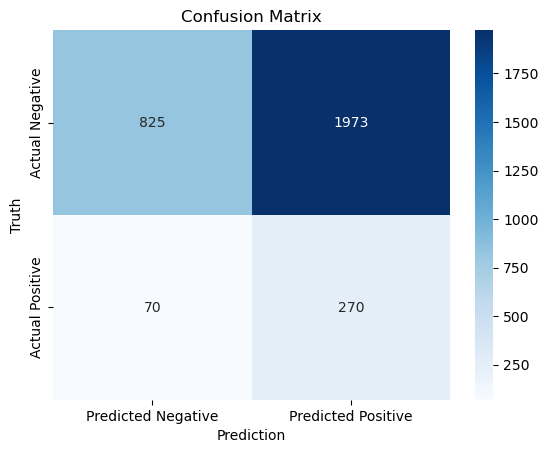

Patient based model: 1
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
     0.605882       0.335217  0.664783   0.0861564   0.470549    0.0463755    0.348927


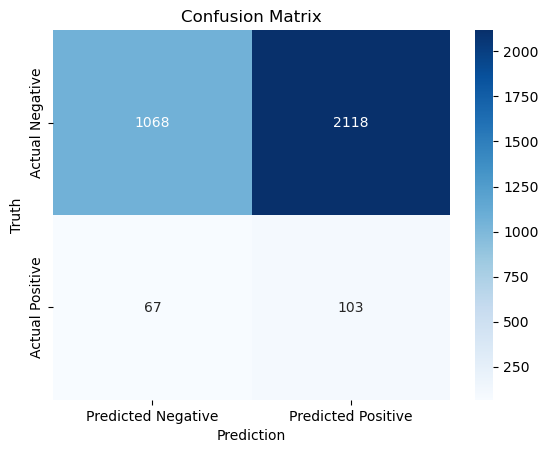

Patient based model: 2
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
          0.6       0.571278  0.428722    0.116505   0.585639    0.0645161    0.572627


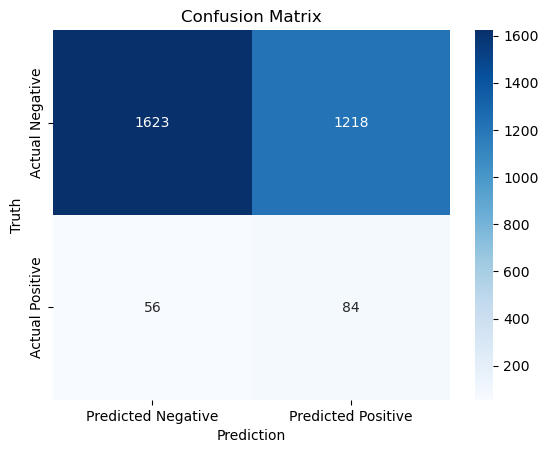

Patient based model: 3
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
      0.84507       0.170288  0.829712   0.0839454   0.507679    0.0441664    0.199572


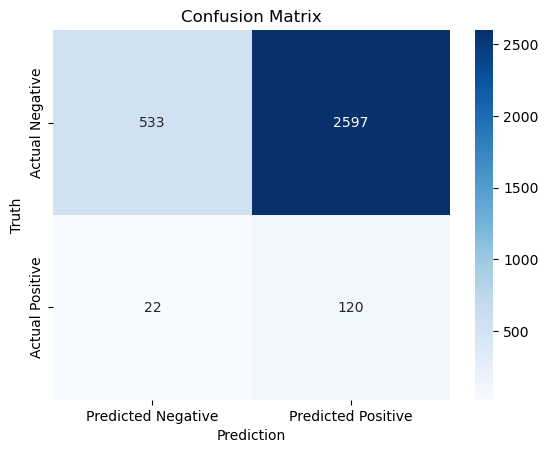

Patient based model: 4
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
     0.633484       0.493405  0.506595    0.150619   0.563445    0.0854701    0.503147


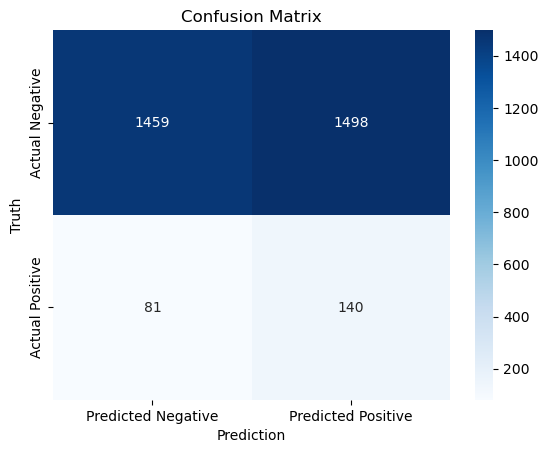

Patient based model: 5
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
     0.811388       0.458419  0.541581    0.218705   0.634904     0.126386    0.489502


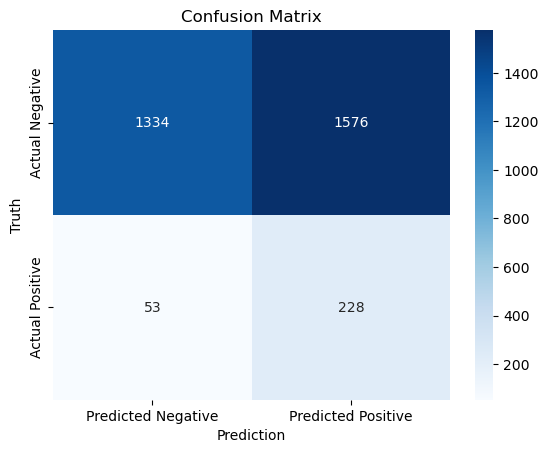

In [ ]:
# Get patient based models and scores
patient_based_models_sw, patient_based_scores_sw = get_models_and_scores(patient_based_train_sw, patient_based_test_sw, has_overlaps=True)

In [ ]:
# Compute average results for the patient based models
scores_array_sw = np.array(patient_based_scores_sw)

# Calculate the mean along the axis 0 (column-wise)
scores_mean_sw = np.mean(scores_array_sw, axis=0)

# Define the metric names
metric_names = ['Sensitivity', 'Specificity', 'FPR', 'F1 Score', 'ROC AUC', 'Precision', 'Accuracy']

# Print the average results
print('  {:<13}  {:<13}  {:<9}  {:<11}  {:<10}  {:<12}  {:<8}'.format(*metric_names))
print('-' * 90)
print('  {:<13.2f}  {:<13.7f}  {:<9.6f}  {:<11.6f}  {:<10.6f}  {:<12.7f}  {:<8.6f}'.format(*scores_mean_sw))

  Sensitivity    Specificity    FPR        F1 Score     ROC AUC     Precision     Accuracy
------------------------------------------------------------------------------------------
  0.71           0.3872433      0.612757   0.144165     0.551117    0.0812147     0.410454


## Using dataset without overlaps

In [ ]:
# Split the data into train and test sets using patient based fashion
patient_based_train = []
patient_based_test = []

for i in range(NUM_PATIENTS):
    patient_train, patient_test = patient_train_test(df_features[df_features['patient_id']==i+1], masks_1[i], masks_2[i], i, has_overlaps=False)
    patient_based_train.append(patient_train)
    patient_based_test.append(patient_test)

15
9
7
8
13
15


In [ ]:
# Check the patient based training set
patient_based_train

[      is_spindle  patient_id      SpEn     maximum     minimum     variance   
 13             0           1  1.466337    7.468567  -11.395536    16.768305  \
 51             0           1  1.098612    4.064229  -17.717459    24.151015   
 54             0           1  3.178054    9.014135   -8.483364    19.575959   
 61             0           1  1.791759    9.632715  -10.269211    26.752819   
 65             0           1  2.397895   14.014975   -8.030347    25.367513   
 178            0           1  0.693147   24.438634   -8.481852    54.827563   
 191            0           1  1.504077   12.716943  -18.213345    38.051397   
 209            0           1  0.916291   42.912081  -85.530139   871.031477   
 228            0           1  3.178054  107.971312  -52.290337   965.759510   
 285            0           1  0.668455  -87.451178 -181.811104   808.355201   
 407            0           1  3.178054   26.058968   -4.584171    49.425067   
 447            0           1  1.791759 

Patient based model: 0
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
     0.689815       0.302366  0.697634    0.149975    0.49609    0.0841333    0.335301


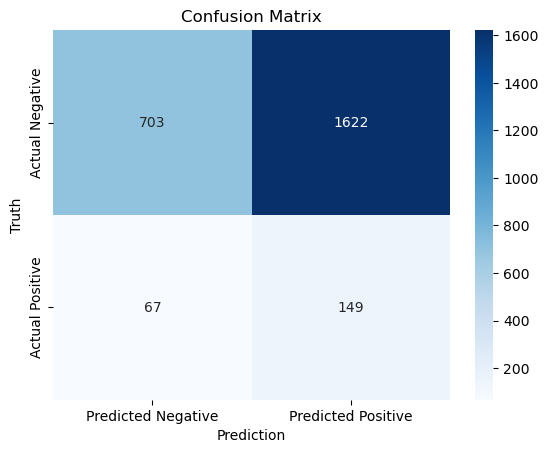

Patient based model: 1
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
     0.458647       0.462918  0.537082   0.0622132   0.460782    0.0333698    0.462752


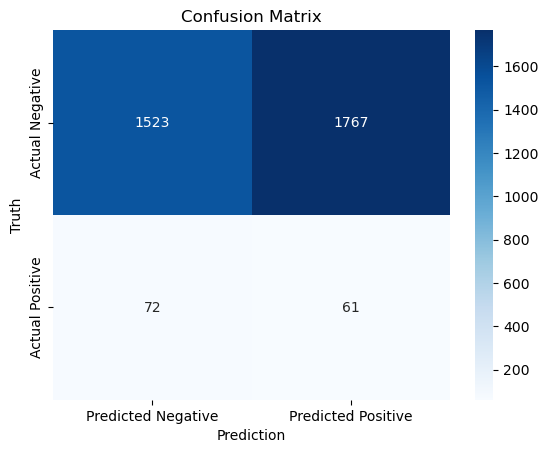

Patient based model: 2
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
     0.622222       0.489737  0.510263   0.0806335    0.55598    0.0431101    0.494458


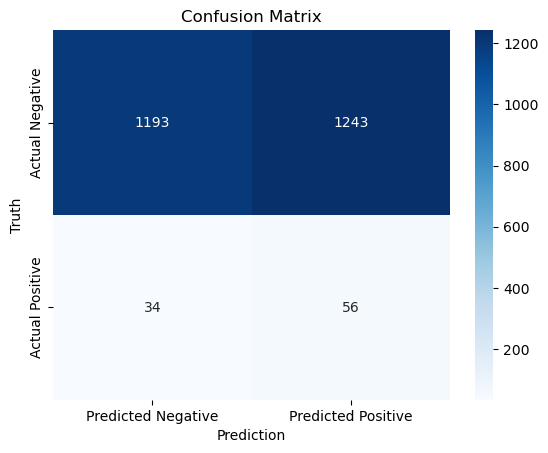

Patient based model: 3
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
     0.683761       0.375821  0.624179   0.0699301   0.529791    0.0368494    0.386213


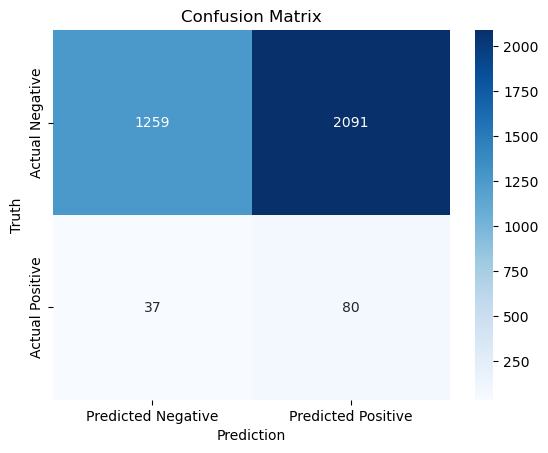

Patient based model: 4
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
     0.320442       0.715826  0.284174    0.102203   0.518134    0.0607966    0.694361


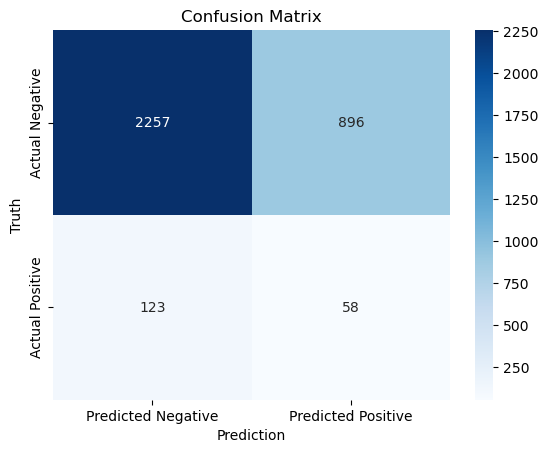

Patient based model: 5
  Sensitivity    Specificity       FPR    F1 Score    ROC AUC    Precision    Accuracy
-------------  -------------  --------  ----------  ---------  -----------  ----------
     0.919048      0.0663686  0.933631    0.123797   0.492708    0.0663686    0.123797


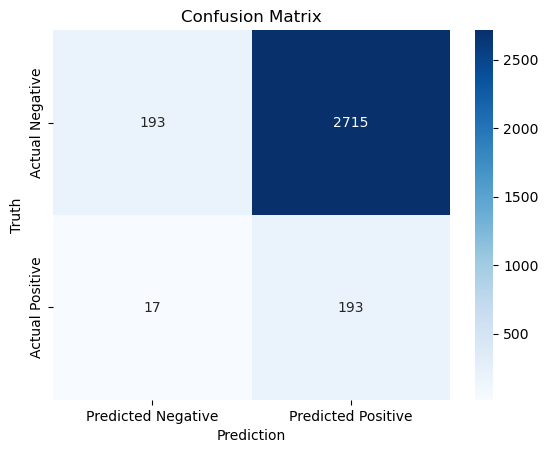

In [ ]:
# Get patient based models and scores
patient_based_models, patient_based_scores = get_models_and_scores(patient_based_train, patient_based_test)

In [ ]:
# Compute average results for the patient based models
scores_array = np.array(patient_based_scores)

# Calculate the mean along the axis 0 (column-wise)
scores_mean = np.mean(scores_array, axis=0)

# Define the metric names
metric_names = ['Sensitivity', 'Specificity', 'FPR', 'F1 Score', 'ROC AUC', 'Precision', 'Accuracy']

# Print the average results for the dataset without overlaps
print('  {:<13}  {:<13}  {:<9}  {:<11}  {:<10}  {:<12}  {:<8}'.format(*metric_names))
print('-' * 90)
print('  {:<13.2f}  {:<13.7f}  {:<9.6f}  {:<11.6f}  {:<10.6f}  {:<12.7f}  {:<8.6f}'.format(*scores_mean))

  Sensitivity    Specificity    FPR        F1 Score     ROC AUC     Precision     Accuracy
------------------------------------------------------------------------------------------
  0.62           0.4021728      0.597827   0.098125     0.508914    0.0541046     0.416147


In [ ]:
# Print the average results for the dataset with overlaps
print('  {:<13}  {:<13}  {:<9}  {:<11}  {:<10}  {:<12}  {:<8}'.format(*metric_names))
print('-' * 90)
print('  {:<13.2f}  {:<13.7f}  {:<9.6f}  {:<11.6f}  {:<10.6f}  {:<12.7f}  {:<8.6f}'.format(*scores_mean_sw))

  Sensitivity    Specificity    FPR        F1 Score     ROC AUC     Precision     Accuracy
------------------------------------------------------------------------------------------
  0.71           0.3872433      0.612757   0.144165     0.551117    0.0812147     0.410454
